#EDA портретів клієнтів

**EDA (Exploratory data analysis)** - is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and ther data visualization methods.

Data was taken at https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis


**Content Attributes**

People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise
- Z_CostContact:
-	Z_Revenue:


Products
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

Promotion
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0
 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place
- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

#Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.cm as cm
import seaborn as sns

from IPython.display import display, HTML
from operator import index

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Functions

Аналіз числових даних

In [ ]:
def info_num_cols (df, col_n):
    col_n = df[col_n]
    mean = round(col_n.mean(), 2)
    mode = col_n.mode()[0]
    median = col_n.median()
    min = col_n.min()
    max = col_n.max()

    qua = col_n.quantile(q = [0.01, 0.25, 0.5, 0.75, 0.99, 1])

    print (f'Середнє значення: {mean}')
    print (f'Мода: {mode}')
    print (f'Медіана: {median}')
    print (f'Персентилі:{qua}')
    print (f'Мінімальне:{min}')
    print (f'Максимальне:{max}')

    #розподіл даних
    plt.figure(figsize=(10, 6))
    sns.histplot(col_n, kde=True, color="skyblue", bins=10)
    plt.title("Розподіл даних", fontsize=16)
    plt.xlabel("Значення", fontsize=14)
    plt.ylabel("Частота", fontsize=14)
    plt.grid(True)
    plt.show()

    #бокс-плот
    sns.boxplot(col_n)
    plt.show()
    return

def descr_num_cols(df):
    cols_num = df.select_dtypes(include = ['int64', 'float64']).columns
    for col_n in cols_num:
      display(HTML(f"<h2><b>Аналіз колонки {col_n}</b></h2>"))
      info_num_cols(df, col_n)
    return

# повна кореляційна матриця
def corr_map (df):
   corr_df = df.select_dtypes(include='number').corr()
   plt.figure(figsize = (25,25))
   sns.heatmap(data = corr_df*100, annot = True, cmap = "RdYlGn", cbar = True, fmt='.0f')
   plt.show()

#корреляційна матриця від визначеного відсотка корреляції
def heat_corr (df, min_cor):
    corr_df = df.select_dtypes(include='number').corr()
    plt.figure(figsize = (25,25))
    sns.heatmap(data = corr_df[(corr_df >= min_cor) & (corr_df < 0.99)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
    plt.show()

    df_list = corr_df[(corr_df >= min_cor)&(corr_df <= 0.99)].unstack().sort_values(ascending = False).head(30)
    df_list = df_list.apply(lambda x: f"{x:.2f}")

    return df_list

def kde(df, column):
    plt.figure(figsize = (14,6))
    sns.kdeplot(df[column],label = column)
    plt.ticklabel_format(style='plain')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()

Формування автоматичного звіту:

In [ ]:
# Перевірка на наявність викидів
def chek_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return IQR, lower_bound, upper_bound

# Визначення викидів
def ident_outliers(df, col, IQR, lower_bound, upper_bound):
    outliers_min = df[col][df[col] < lower_bound]
    outliers_max = df[col][df[col] > upper_bound]
    if not outliers_min.empty:
        min_outliers_text = f"Викиди від {df[col].min()} до {lower_bound}"
    else:
        min_outliers_text = None

    if not outliers_max.empty:
        max_outliers_text = f"Викиди від {upper_bound} до {df[col].max()}"
    else:
        max_outliers_text = None

    return min_outliers_text, max_outliers_text, outliers_min, outliers_max

# Заповнення колонки "Викиди" з урахуванням викидів знизу і зверху
def fill_outliers(df_columns, col, min_outliers_text, max_outliers_text):
    if min_outliers_text and max_outliers_text:
        df_columns.loc[col, 'Викиди'] = f"{min_outliers_text}; {max_outliers_text}"
    elif min_outliers_text:
        df_columns.loc[col, 'Викиди'] = min_outliers_text
    elif max_outliers_text:
        df_columns.loc[col, 'Викиди'] = max_outliers_text
    else:
        df_columns.loc[col, 'Викиди'] = 'Немає викидів'

    return df_columns

# Функція для визначення викидів та заповнення інформації про них
def outliers(df, df_columns, col):
    IQR, lower_bound, upper_bound = chek_outliers(df, col)
    min_outliers_text, max_outliers_text, outliers_min, outliers_max = ident_outliers(df, col, IQR, lower_bound, upper_bound)
    df_columns = fill_outliers(df_columns, col, min_outliers_text, max_outliers_text)

    return df_columns, outliers_min, outliers_max

# Визначення ступеня асиметрії
def skew_degree(skewness):
    if abs(skewness) < 0.25:
        skew_degree = "Слабка"
    elif 0.25 <= abs(skewness) < 0.5:
        skew_degree = "Середня"
    else:
        skew_degree = "Сильна"

    return skew_degree

# Напрямок асиметрії
def skew_direct(skewness):
    if skewness > 0:
        skew_direction = "Правостороння"
    elif skewness < 0:
        skew_direction = "Лівостороння"
    else:
        skew_direction = "Симетрична"

    return skew_direction

def skew(skewness):
    skew_degree_value = skew_degree(skewness)
    skew_direction = skew_direct(skewness)

    return skew_degree_value, skew_direction

# Додаємо інформацію про розподіл, асиметрію, її напрямок і ступінь
def data_distr(df, df_columns, col):
    skewness = df[col].skew()
    skew_degree_value, skew_direction = skew(skewness)

    # Підсумковий опис розподілу
    if skew_direction == "Симетрична":
        distribution_desc = "Нормальний"
    else:
        distribution_desc = f"Ненормальний ({skew_direction}, {skew_degree_value} асиметрія)"

    df_columns.loc[col, 'Розподіл_даних'] = distribution_desc

    return df_columns, distribution_desc, skew_direction

# Додаємо колонку "що зробити" з рекомендаціями для кластеризації
def plan(df_columns, col, outliers_min, outliers_max, distribution_desc, skew_direction):
    if not outliers_min.empty or not outliers_max.empty:
        df_columns.loc[col, 'План_дій'] = 'Розглянути видалення або заміну викидів'
    elif distribution_desc != 'Нормальний':
        # Рекомендації щодо нормалізації для кластеризації
        if skew_direction == "Правостороння":
            norm_method = "Логарифмічне або квадратний корінь"
        elif skew_direction == "Лівостороння":
            norm_method = "Квадрат або інверсія"
        else:
            norm_method = "Мін-макс або стандартизація"

        df_columns.loc[col, 'План_дій'] = f'Розглянути трансформацію ({norm_method}) для кластеризації'
    else:
        df_columns.loc[col, 'План_дій'] = 'Нічого не потрібно'

    return df_columns

# Заповнення інформації про колонку
def fill_col(df, df_columns, df_num, col):
    # Вносимо назву колонки
    df_columns.loc[col, 'Назва колонки'] = col

    df_columns, outliers_min, outliers_max = outliers(df, df_columns, col)
    df_columns, distribution_desc, skew_direction = data_distr(df, df_columns, col)
    df_columns = plan(df_columns, col, outliers_min, outliers_max, distribution_desc, skew_direction)

    return df_columns


# Основна функція створення звіту
def creat_zvit_num(df):
    # Створення нового DataFrame для аналізу колонок
    column_names = ['Назва колонки', 'Викиди', 'Розподіл_даних', 'План_дій', 'Висновки']
    df_columns = pd.DataFrame(columns=column_names)

    # Фільтрація тільки числових колонок (float та int)
    df_num = df.select_dtypes(include=['int64', 'float64'])

    # Заповнюємо df_columns інформацією
    for col in df_num.columns:
        df_columns = fill_col(df, df_columns, df_num, col)

    # Заміна індексів з назвами колонок на числові індекси
    df_columns.reset_index(drop=True, inplace=True)

    return df_columns


Збагачення даних

In [ ]:
#додавання колонки з кількістю неповнолітніх
def add_minor (df):
    df['Minor'] = df['Kidhome'] + df['Teenhome']
    return df

def add_mnt (df):
    df['Mnt'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

    return df

def mnt_ads(df):
    columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

    df['Mnt_count'] = df[columns].gt(0).sum(axis=1)

    # Створюємо колонку 'Mnt_count_list' з 0 і 1 для кожного стовпця в залежності від значень
    df['Mnt_count_list'] = df[columns].apply(lambda row: [1 if x > 0 else 0 for x in row], axis=1)

    # Створюємо колонку 'Mnt_type' у вигляді рядка з чисел, розділених комами, для кожного рядка
    df['Mnt_type'] = df['Mnt_count_list'].apply(lambda x: f"{x[0]},{x[1]},{x[2]},{x[3]},{x[4]},{x[5]}")

    return df

def type_minor(df):
    # Якщо df_minor є фрагментом іншого DataFrame, створіть копію для уникнення попереджень
    df = df.copy()

    # Додавання колонки Type_minor як списку з Kidhome і Teenhome
    df['Type_minor'] = df.apply(lambda row: [row['Kidhome'], row['Teenhome']], axis=1)

    df['Type_minor'] = df['Type_minor'].apply(lambda x: f"{x[0]},{x[1]}")

    type_dict = {'0,0': 'немає неповнолітніх',
        '0,1': 'діти(0), підлітки(1)',
        '1,0': 'діти(1), підлітки(0)',
        '0,2': 'діти(0), підлітки(2)',
        '1,1': 'діти(1), підлітки(1)',
        '0,2': 'діти(0), підлітки(2)',
        '1,2': 'діти(1), підлітки(2)',
        '2,1': 'діти(2), підлітки(1)'
        }

    df['Type_minor'] = df.Type_minor.map(type_dict)

    return df

#Import data

In [ ]:
path_to = '/content/drive/MyDrive/Python/ML/DATA/marketing_campaign_1.csv'

In [ ]:
df = pd.read_csv(path_to)
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


#Перевірка структури даних

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Базовий датасет має записи про 2240 клієнтів. Зібрано інформацію за 29 ознакою по кожному клієнту.

In [ ]:
#Аналіз пропущених даних
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
4,Income,24,1.07
0,ID,0,0.00
15,NumDealsPurchases,0,0.00
27,Z_Revenue,0,0.00
26,Z_CostContact,0,0.00
25,Complain,0,0.00
24,AcceptedCmp2,0,0.00
23,AcceptedCmp1,0,0.00
22,AcceptedCmp5,0,0.00
21,AcceptedCmp4,0,0.00


Пропущені дані містить лише колонка 'Income' у 24 рядках, що становить 1.07% записів (клієнтів).

Огляд числових колонок

In [ ]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


##Висновки

1. Набір даних має 2240 entries та 29 колонок.
2. Колонки є наступних типів:
  - float64 - 1(Income)
  - int64 - 25 ('ID', 'Year_Birth', 'Kidhome', 'Teenhome', 'Recency', MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'),
  - object - 3('Education', 'Marital_Status', 'Dt_Customer').
3. В наборі даних є пусті значення. Вони в колонці "Income" і становлять 1.07%.

**З огляду на вище наведене буду робити наступне:**
1. Опрацювання нульових значень в колонці "Income".
2. Тип даних ID має формат int, але вірним буде формат 'str', оскільки по суті це є ідентифікатор;
3. Аналіз на викиди в числових даних;
4. Потрібно опрацювати колонку 'Dt_Customer', бо наразі вона має тип 'object', а має показувати, скільки людина часу з компанією;
5. Створимо ще одну колонку 'Age_client' використавши 'Year_Birth'
6. Опрацювання категоріальних даних;


#Опрацювання даних

**Опрацювання нульових значень в колонці "Income"**

Відсутні значення становлять 1.07% даних по одній з колонок. Повернемось до  питання заміни пустих значень після аналізу розподілу даних та викидів.

**Заміна типу даних "ID"**

Колонка 'ID' наразі має числовий формат. Замінюю тип на 'str'.

In [ ]:
df['ID'] = df['ID'].astype('str')

**Dt_Customer**

У нас відсутня інформація, на яку дату були зібрані дані. Припускаю, що останнім днем періоду за який збиралися дані - останній день реєстрацією на сайті.
Замінимо дату реєстрації на кількість днів, що клієнт з нами.

In [ ]:
# Перетворення колонки 'Dt_Customer' на тип 'datetime' з правильним форматом
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

#створимо колонку з життєвим часом клієнта
today = df.Dt_Customer.max()
df['Days_lifetime'] = (today - df.Dt_Customer).dt.days

In [ ]:
today

Timestamp('2014-06-29 00:00:00')

**'Age_client'**

За рахунок колонки 'Year_Birth' та отриманої дати останьої реєстрації клієнтів на сайті.

Це буде приблизний вік, бо у нас немає  дати народження, а лише рік.
Тому ми від "2014" віднімемо (рік народження - 1). У нас є продажі алкоголю, а заборона визначається повними роками.

In [ ]:
df['Age_client'] = df['Year_Birth'].apply(lambda x: 2014 - (x - 1))

##Висновки
1. Було збагачено дані колонками:
  - 'Days_lifetime' - кількість днів, що клієнт взаємодіє з платформою;
  - 'Age_client' - вік клієнта;
  

#Загальний аналіз числових даних за колонками
**Викиди в даних**
Викид в даних - це точка даних, яка далеко віддалена від інших записів у наборі даних. Викиди можуть бути спричинені:
1. Помилки, допущені при записі даних
2. Дані, які не належать до населення
3. Справжні рідкісні події

Перші два випадки прості у вирішенні, оскільки ми можемо виправити помилки або видалити дані, які не належать до населення. Третій випадок є більш проблематичним, оскільки екстремальні викиди різко збільшать стандартне відхилення та сильно перекосять дані.

Для аналізу наявності викидів в цій частині застосовуют box-plot.
A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

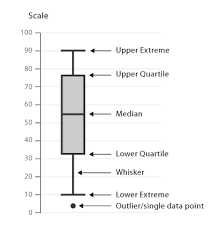

**Аналіз на нормальний розподіл**

Знання про те, чи мають дані нормальний розподіл, важливе для коректного вибору методів аналізу та інтерпретації результатів. Основні причини:

Вибір статистичних методів: Багато статистичних тестів (наприклад, t-тест, ANOVA, кореляція Пірсона) базуються на припущенні нормального розподілу. Якщо дані не є нормально розподіленими, можна отримати некоректні результати або доведеться застосовувати непараметричні методи, які не залежать від типу розподілу.

Оцінка середнього та дисперсії: При нормальному розподілі середнє та дисперсія є надійними показниками тенденції та розсіювання даних. Якщо розподіл значно відрізняється від нормального (наприклад, є сильний перекіс), середнє може вводити в оману, і краще використовувати медіану.

Прогнозування та моделювання: Багато моделей машинного навчання та методів регресії передбачають нормальний розподіл залишків (різниць між спостереженнями та прогнозами). Якщо ці залишки не мають нормального розподілу, точність прогнозів може постраждати.

Побудова довірчих інтервалів: При нормальному розподілі даних можна використовувати стандартні методи для обчислення довірчих інтервалів. За відсутності нормальності ці інтервали можуть бути ненадійними, і потрібно застосовувати інші методи або робити трансформацію даних.

Виявлення аномалій: Нормальний розподіл дозволяє виявляти аномалії, оскільки значення, які сильно відхиляються від середнього, легко ідентифікуються. У ненормальному розподілі такі аномалії важче визначити.

Тому тестування на нормальність допомагає вирішити, які підходи будуть найефективнішими та надійними для аналізу даних.

**Запустимо код для виведення данних по числовим колонкам**

Середнє значення: 1968.81
Мода: 1976
Медіана: 1970.0
Персентилі:0.01    1945.0
0.25    1959.0
0.50    1970.0
0.75    1977.0
0.99    1992.0
1.00    1996.0
Name: Year_Birth, dtype: float64
Мінімальне:1893
Максимальне:1996


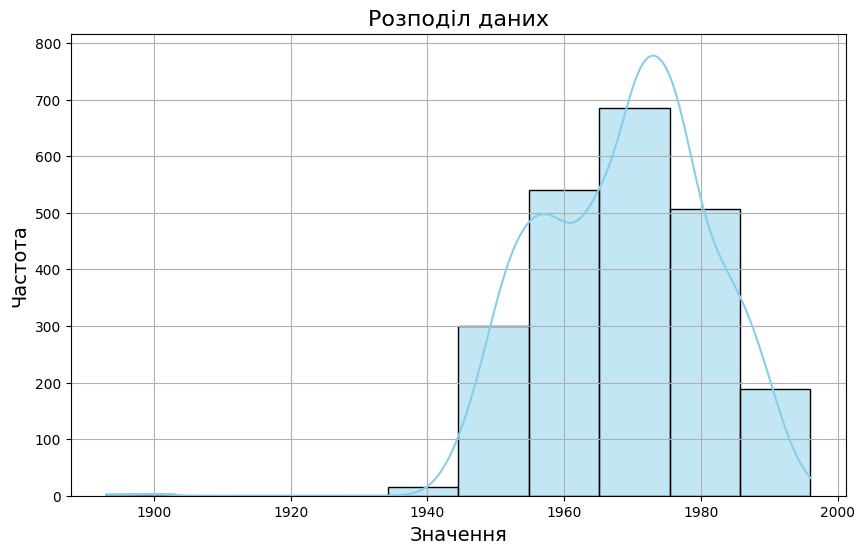

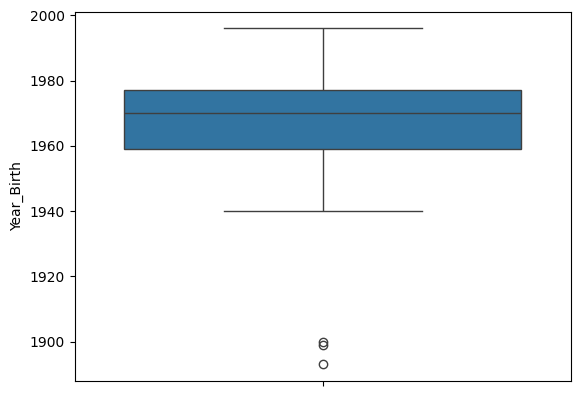

Середнє значення: 52247.25
Мода: 7500.0
Медіана: 51381.5
Персентилі:0.01      7579.2
0.25     35303.0
0.50     51381.5
0.75     68522.0
0.99     94458.8
1.00    666666.0
Name: Income, dtype: float64
Мінімальне:1730.0
Максимальне:666666.0


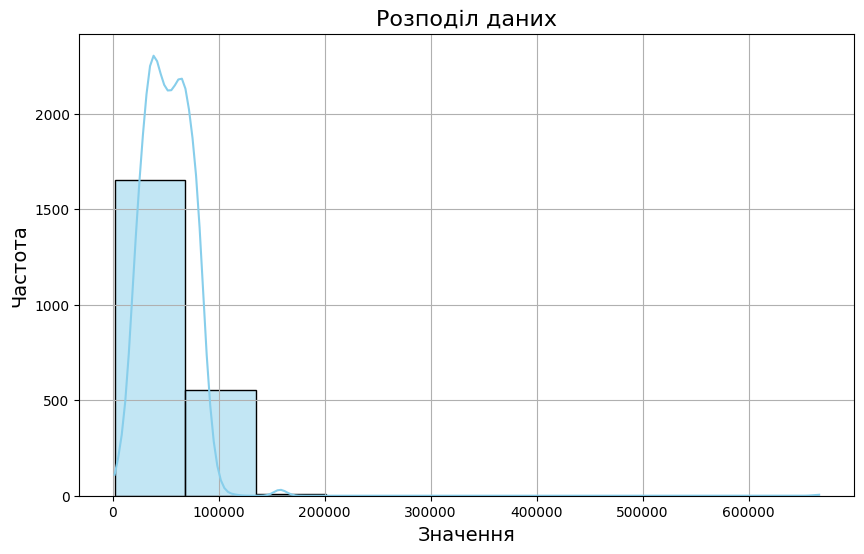

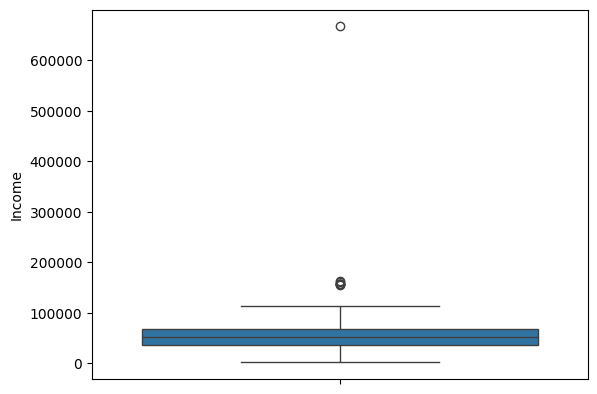

Середнє значення: 0.44
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    1.0
0.99    2.0
1.00    2.0
Name: Kidhome, dtype: float64
Мінімальне:0
Максимальне:2


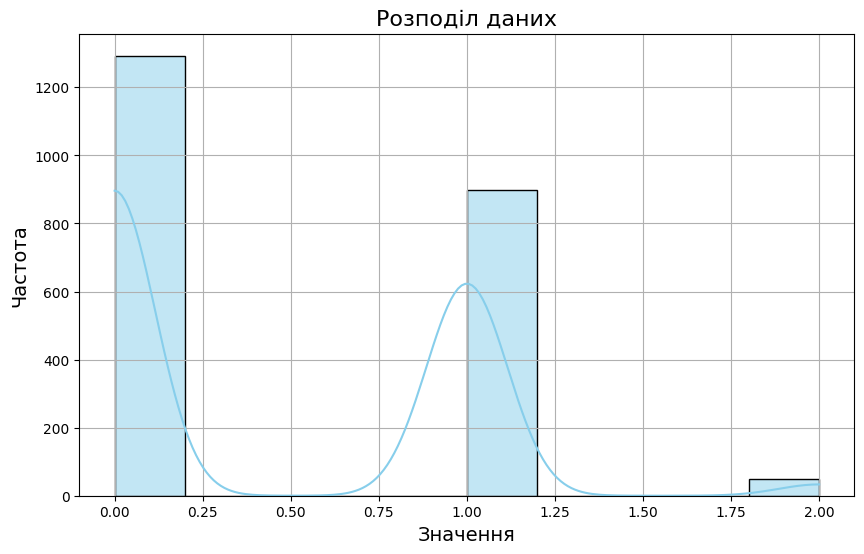

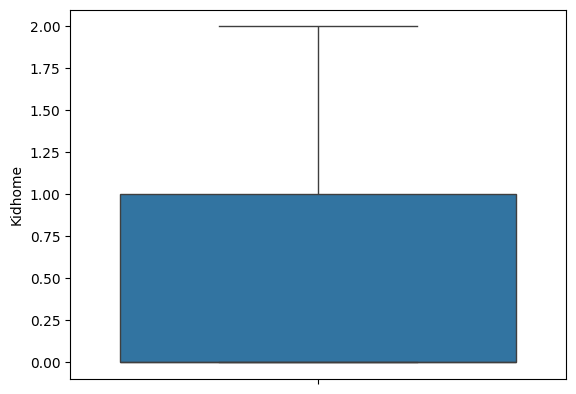

Середнє значення: 0.51
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    1.0
0.99    2.0
1.00    2.0
Name: Teenhome, dtype: float64
Мінімальне:0
Максимальне:2


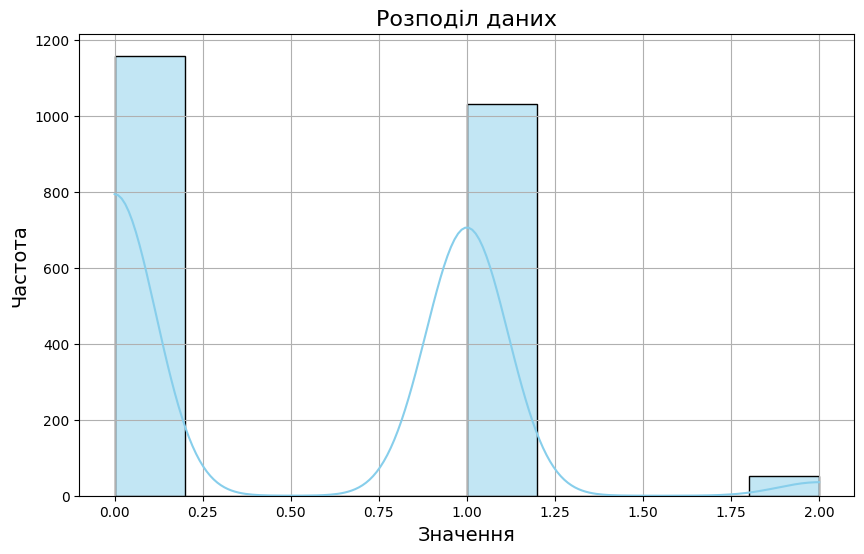

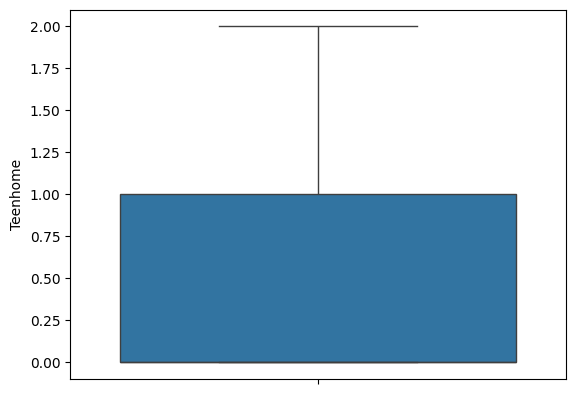

Середнє значення: 49.11
Мода: 56
Медіана: 49.0
Персентилі:0.01     0.0
0.25    24.0
0.50    49.0
0.75    74.0
0.99    98.0
1.00    99.0
Name: Recency, dtype: float64
Мінімальне:0
Максимальне:99


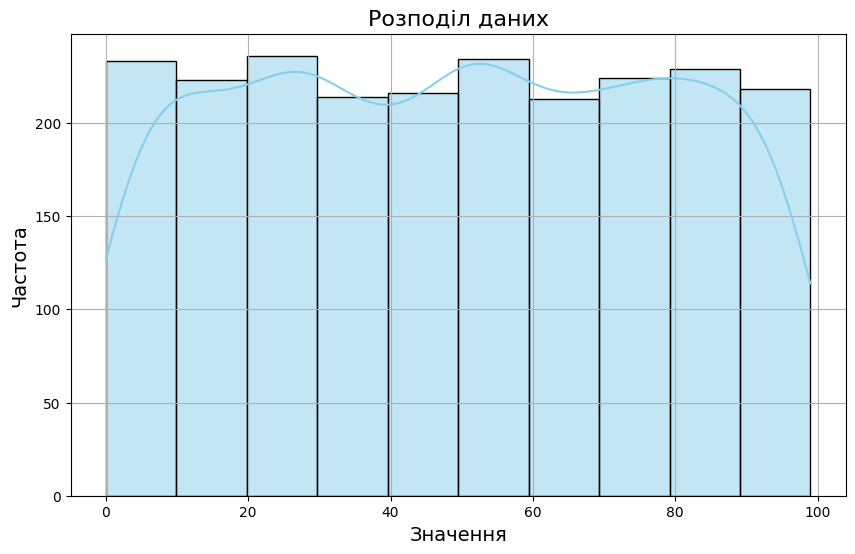

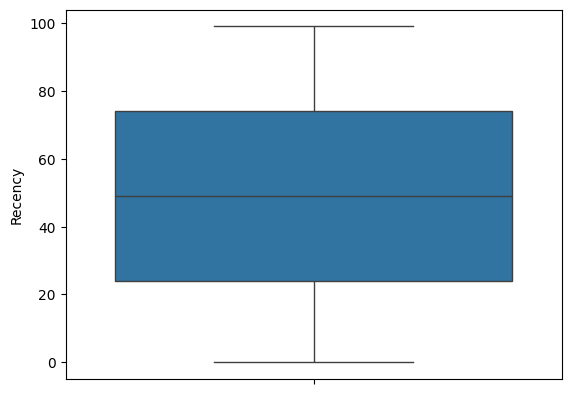

Середнє значення: 303.94
Мода: 2
Медіана: 173.5
Персентилі:0.01       1.00
0.25      23.75
0.50     173.50
0.75     504.25
0.99    1285.00
1.00    1493.00
Name: MntWines, dtype: float64
Мінімальне:0
Максимальне:1493


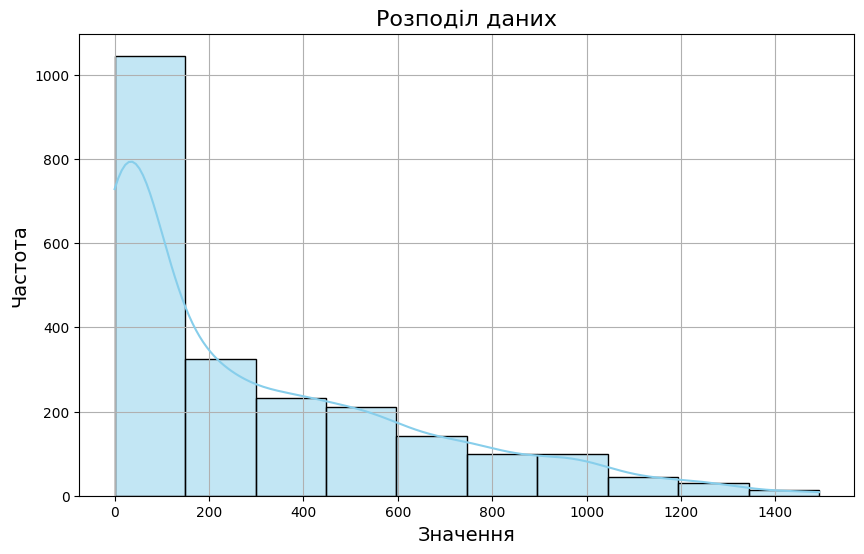

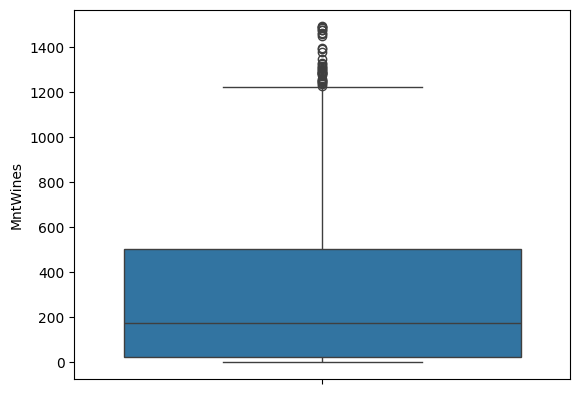

Середнє значення: 26.3
Мода: 0
Медіана: 8.0
Персентилі:0.01      0.0
0.25      1.0
0.50      8.0
0.75     33.0
0.99    172.0
1.00    199.0
Name: MntFruits, dtype: float64
Мінімальне:0
Максимальне:199


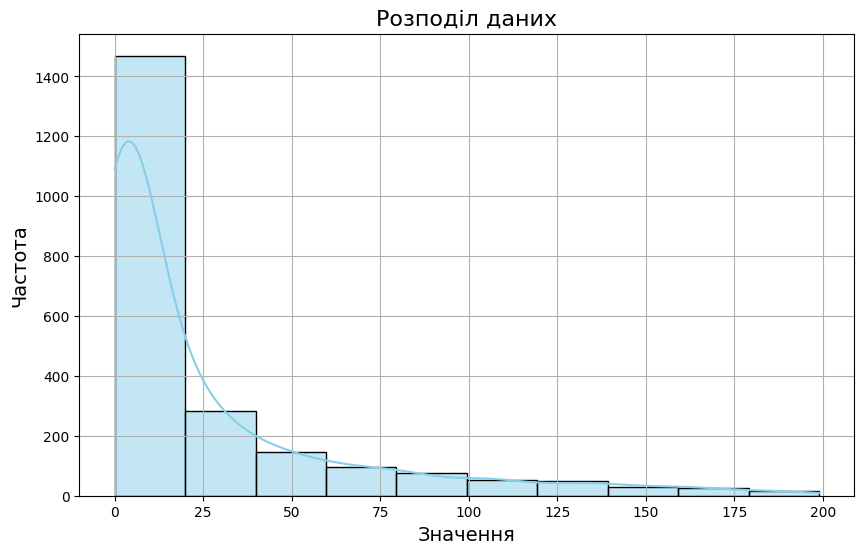

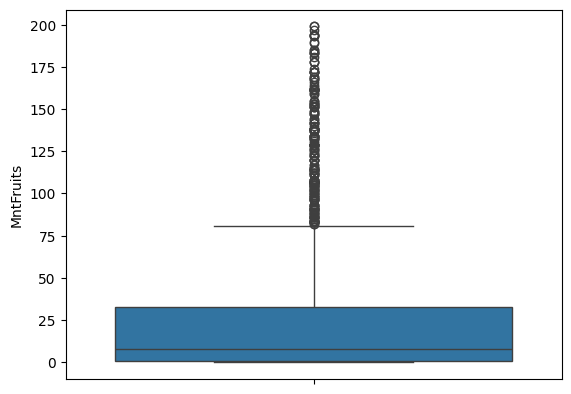

Середнє значення: 166.95
Мода: 7
Медіана: 67.0
Персентилі:0.01       2.0
0.25      16.0
0.50      67.0
0.75     232.0
0.99     915.0
1.00    1725.0
Name: MntMeatProducts, dtype: float64
Мінімальне:0
Максимальне:1725


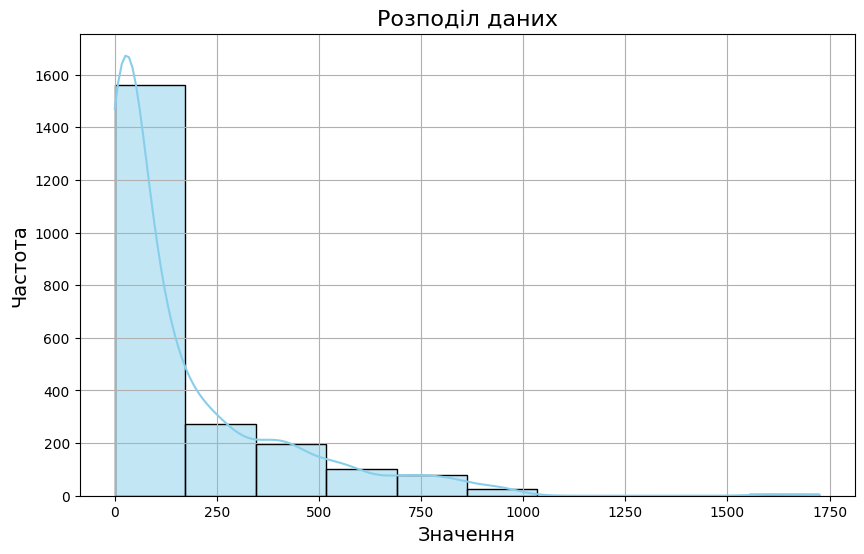

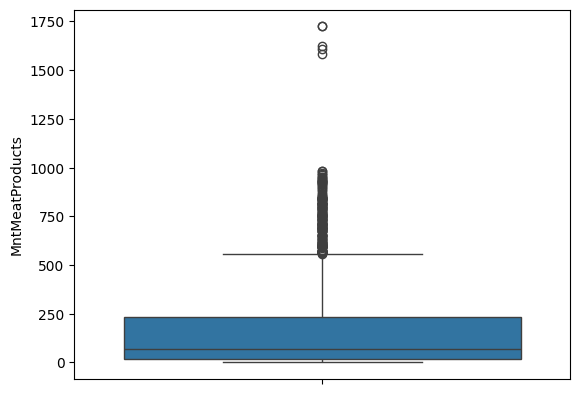

Середнє значення: 37.53
Мода: 0
Медіана: 12.0
Персентилі:0.01      0.00
0.25      3.00
0.50     12.00
0.75     50.00
0.99    226.22
1.00    259.00
Name: MntFishProducts, dtype: float64
Мінімальне:0
Максимальне:259


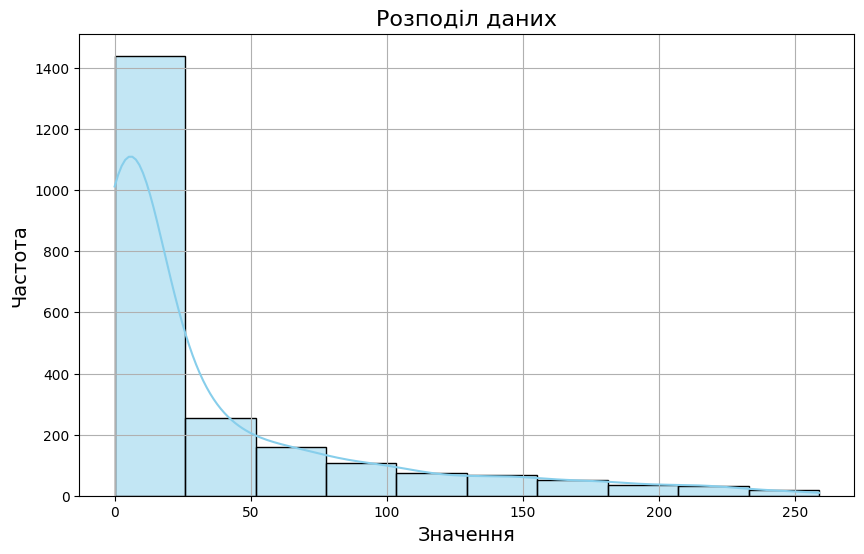

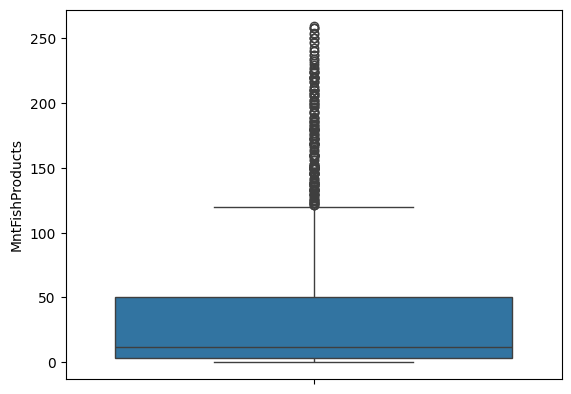

Середнє значення: 27.06
Мода: 0
Медіана: 8.0
Персентилі:0.01      0.00
0.25      1.00
0.50      8.00
0.75     33.00
0.99    177.22
1.00    263.00
Name: MntSweetProducts, dtype: float64
Мінімальне:0
Максимальне:263


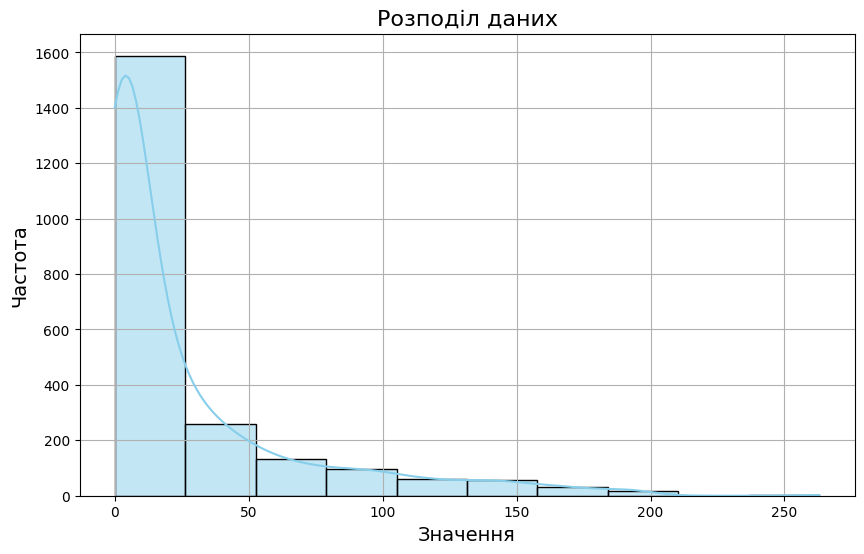

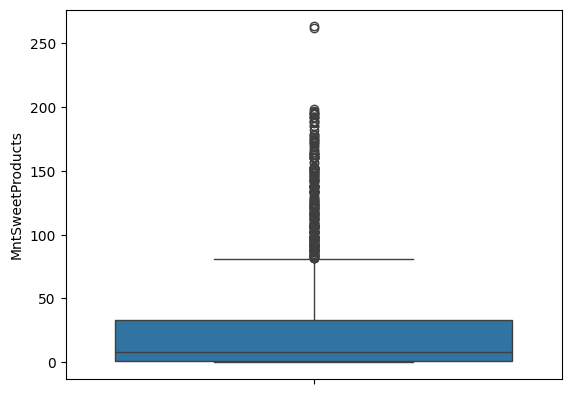

Середнє значення: 44.02
Мода: 1
Медіана: 24.0
Персентилі:0.01      0.0
0.25      9.0
0.50     24.0
0.75     56.0
0.99    227.0
1.00    362.0
Name: MntGoldProds, dtype: float64
Мінімальне:0
Максимальне:362


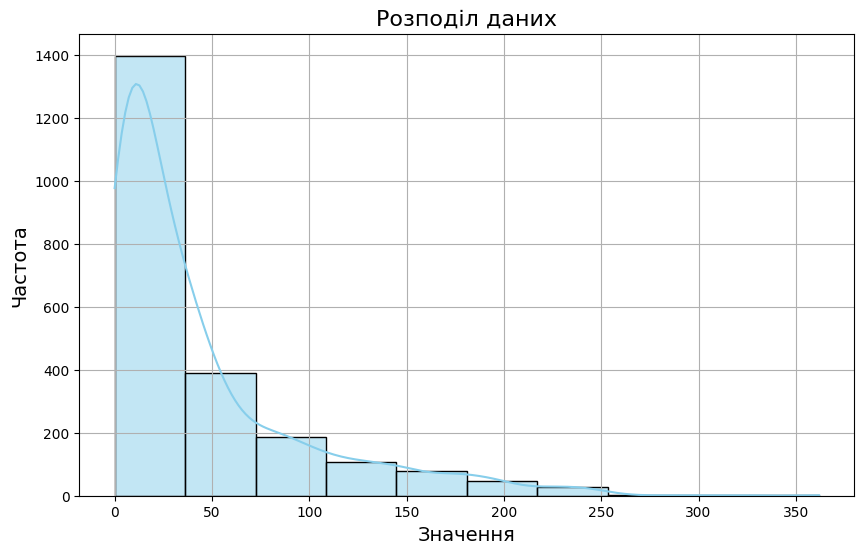

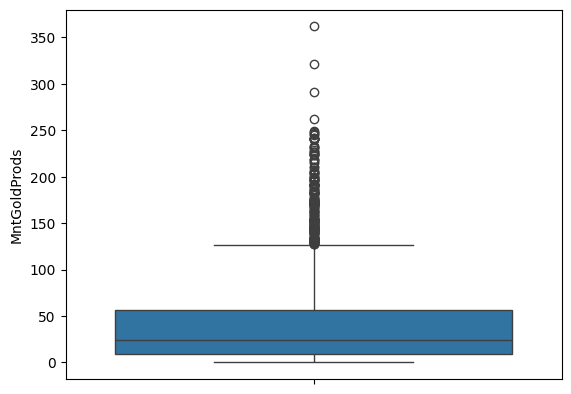

Середнє значення: 2.33
Мода: 1
Медіана: 2.0
Персентилі:0.01     0.0
0.25     1.0
0.50     2.0
0.75     3.0
0.99    10.0
1.00    15.0
Name: NumDealsPurchases, dtype: float64
Мінімальне:0
Максимальне:15


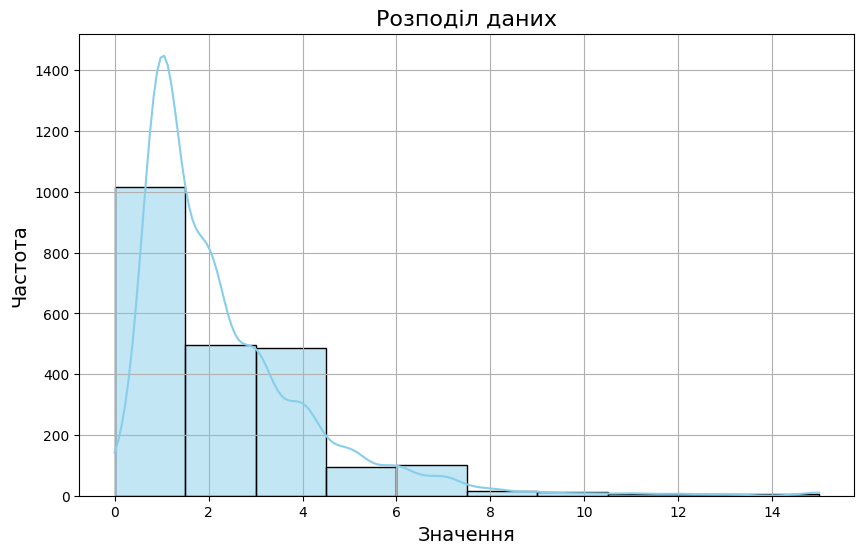

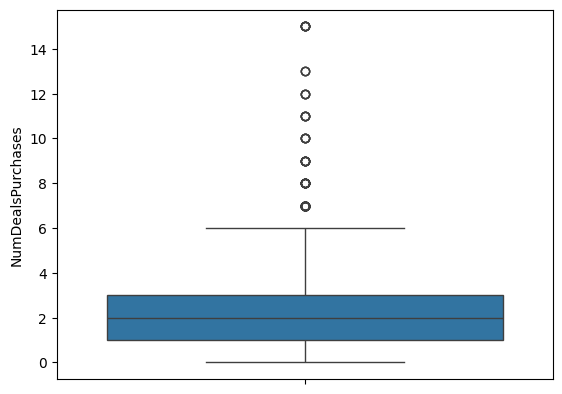

Середнє значення: 4.08
Мода: 2
Медіана: 4.0
Персентилі:0.01     0.0
0.25     2.0
0.50     4.0
0.75     6.0
0.99    11.0
1.00    27.0
Name: NumWebPurchases, dtype: float64
Мінімальне:0
Максимальне:27


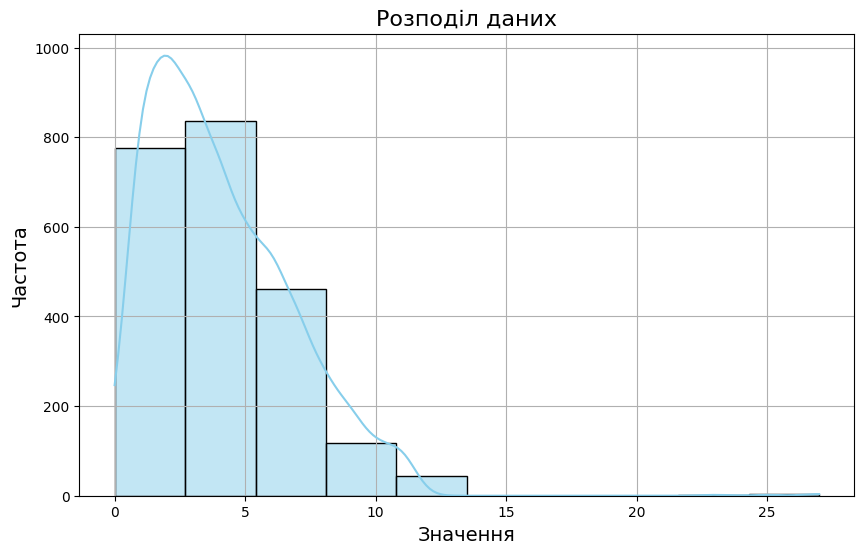

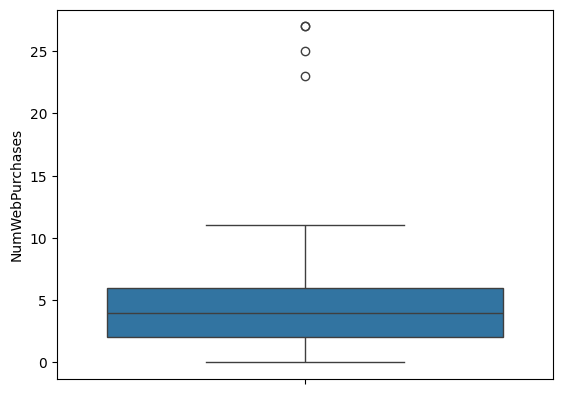

Середнє значення: 2.66
Мода: 0
Медіана: 2.0
Персентилі:0.01     0.00
0.25     0.00
0.50     2.00
0.75     4.00
0.99    10.61
1.00    28.00
Name: NumCatalogPurchases, dtype: float64
Мінімальне:0
Максимальне:28


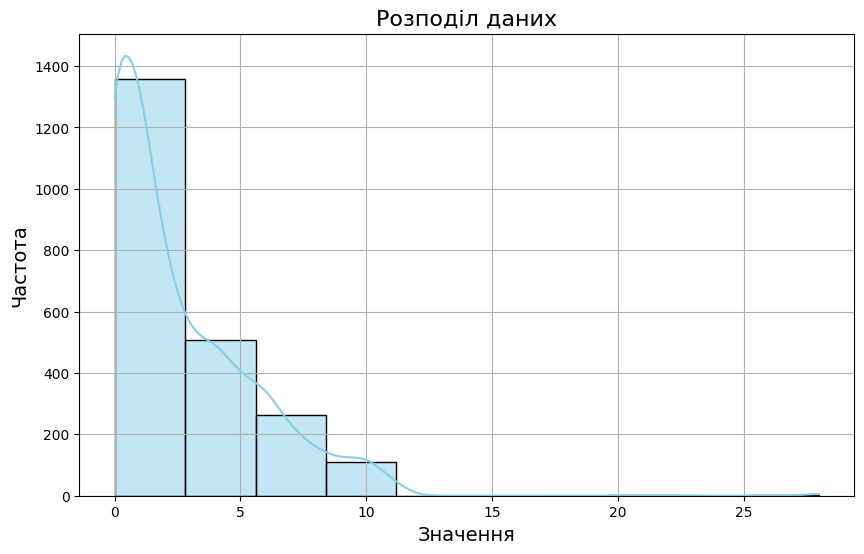

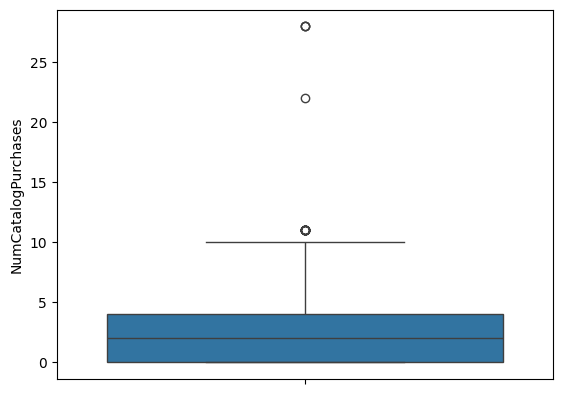

Середнє значення: 5.79
Мода: 3
Медіана: 5.0
Персентилі:0.01     2.0
0.25     3.0
0.50     5.0
0.75     8.0
0.99    13.0
1.00    13.0
Name: NumStorePurchases, dtype: float64
Мінімальне:0
Максимальне:13


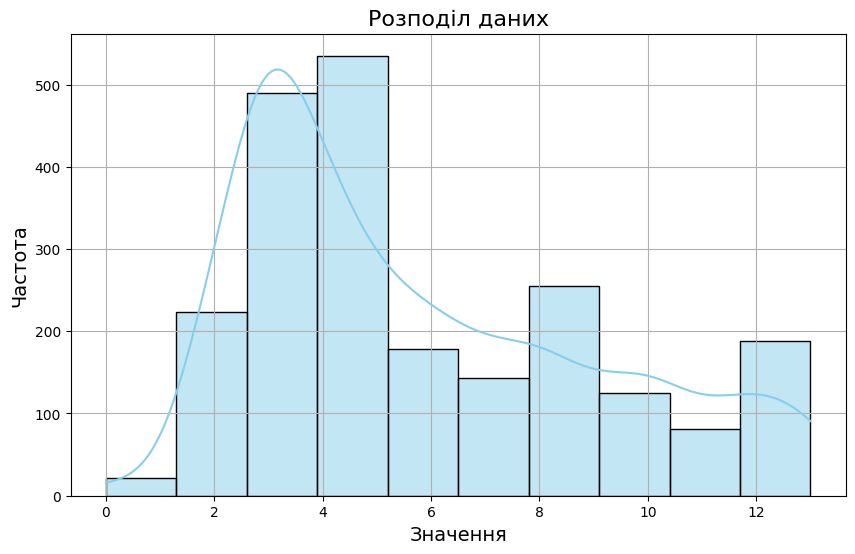

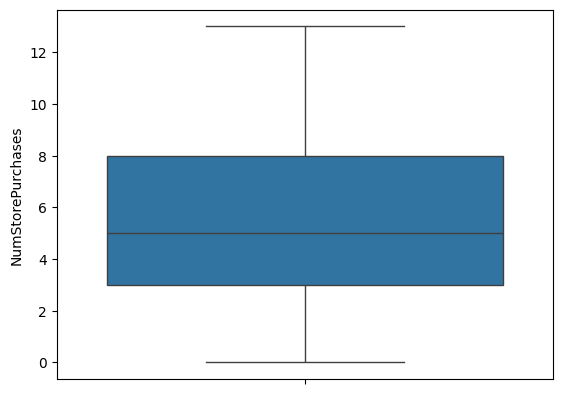

Середнє значення: 5.32
Мода: 7
Медіана: 6.0
Персентилі:0.01     1.0
0.25     3.0
0.50     6.0
0.75     7.0
0.99     9.0
1.00    20.0
Name: NumWebVisitsMonth, dtype: float64
Мінімальне:0
Максимальне:20


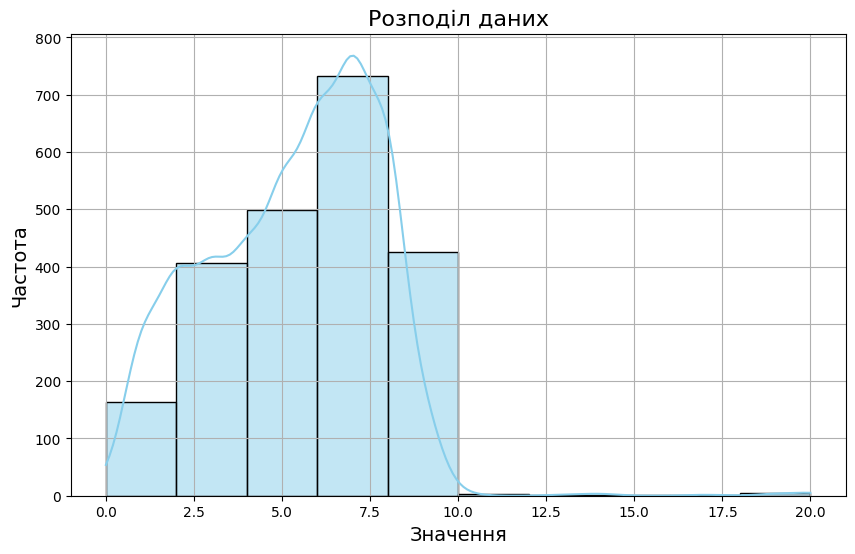

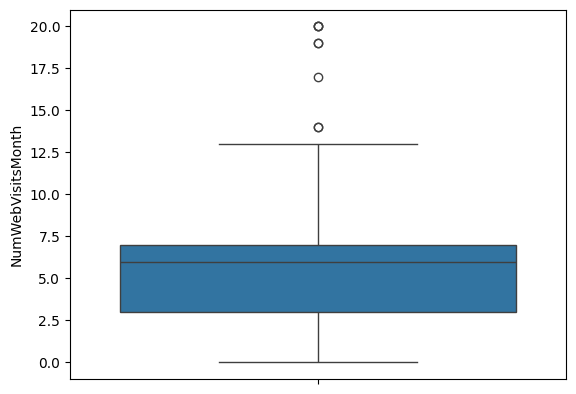

Середнє значення: 0.07
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    0.0
0.99    1.0
1.00    1.0
Name: AcceptedCmp3, dtype: float64
Мінімальне:0
Максимальне:1


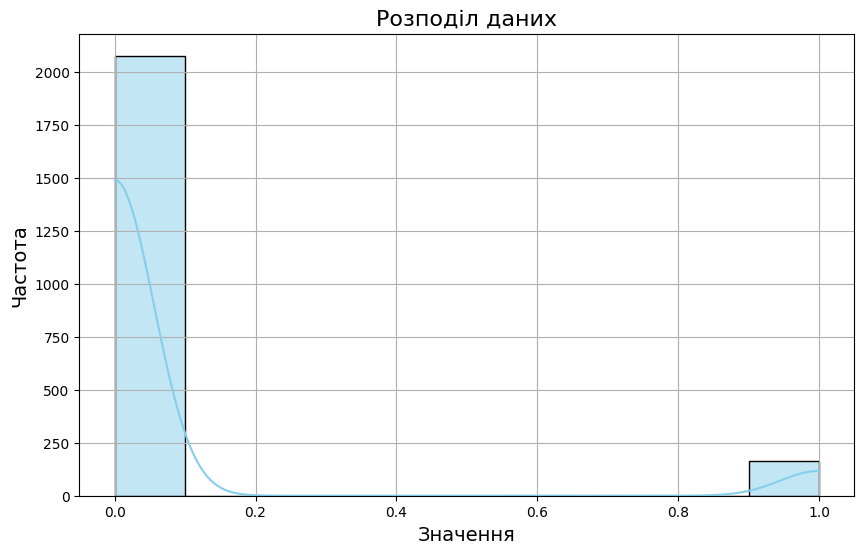

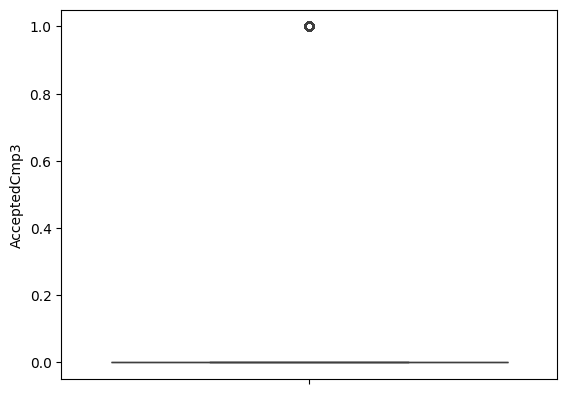

Середнє значення: 0.07
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    0.0
0.99    1.0
1.00    1.0
Name: AcceptedCmp4, dtype: float64
Мінімальне:0
Максимальне:1


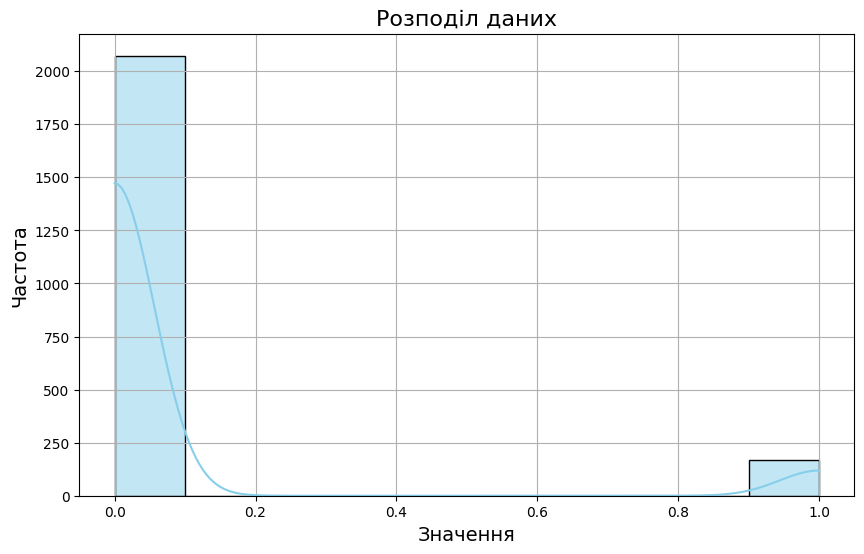

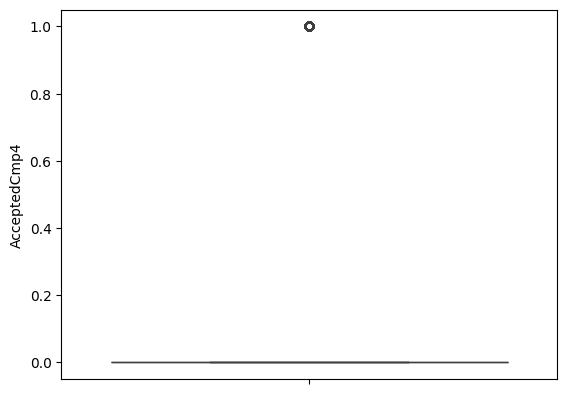

Середнє значення: 0.07
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    0.0
0.99    1.0
1.00    1.0
Name: AcceptedCmp5, dtype: float64
Мінімальне:0
Максимальне:1


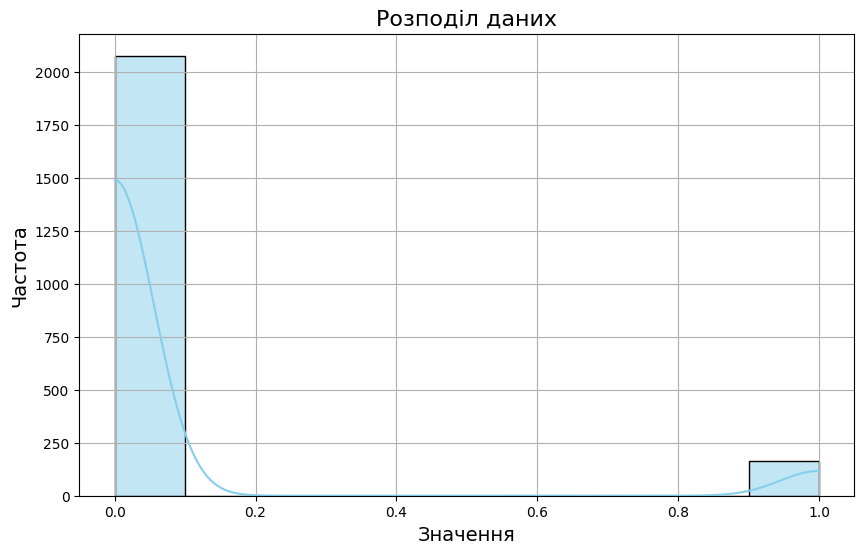

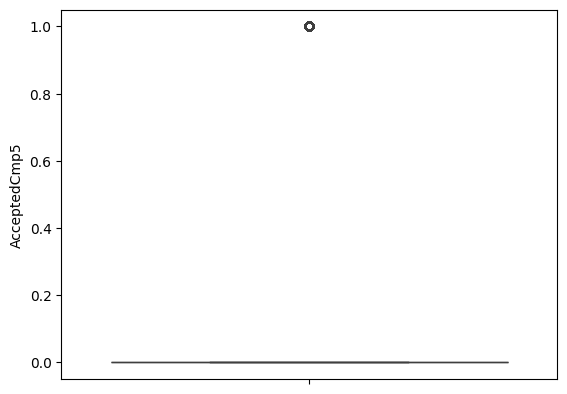

Середнє значення: 0.06
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    0.0
0.99    1.0
1.00    1.0
Name: AcceptedCmp1, dtype: float64
Мінімальне:0
Максимальне:1


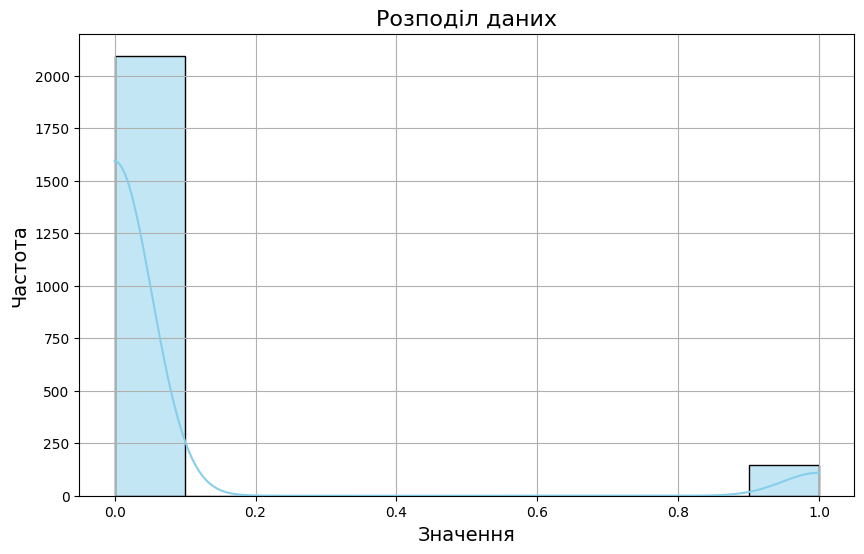

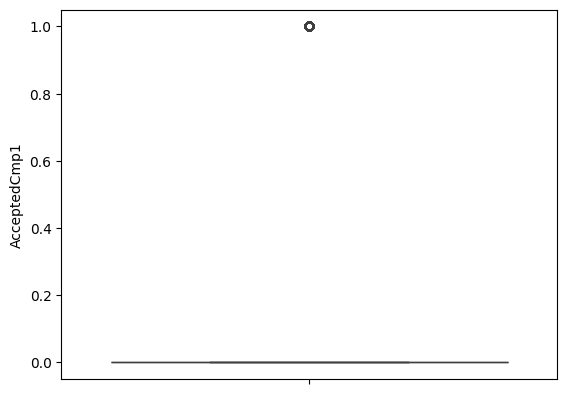

Середнє значення: 0.01
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    0.0
0.99    1.0
1.00    1.0
Name: AcceptedCmp2, dtype: float64
Мінімальне:0
Максимальне:1


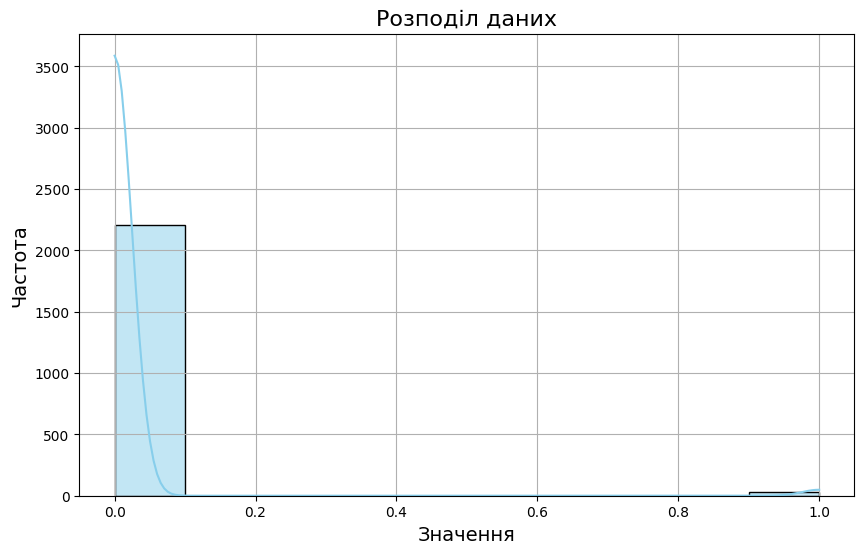

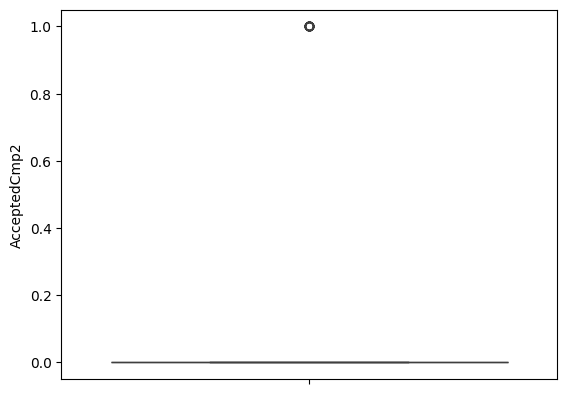

Середнє значення: 0.01
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    0.0
0.99    0.0
1.00    1.0
Name: Complain, dtype: float64
Мінімальне:0
Максимальне:1


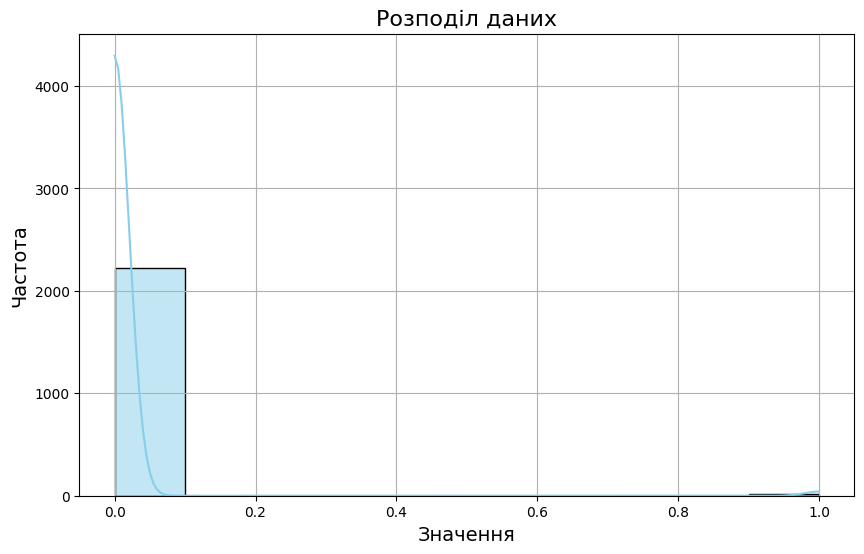

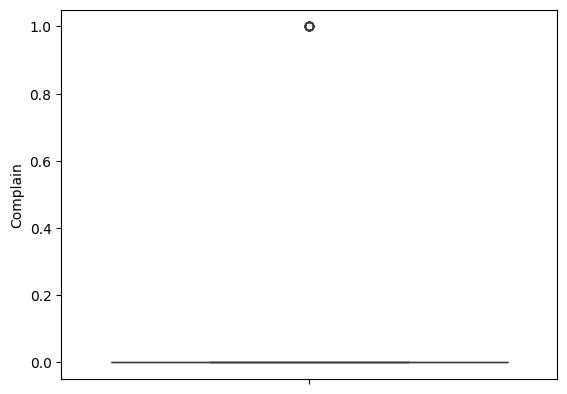

Середнє значення: 3.0
Мода: 3
Медіана: 3.0
Персентилі:0.01    3.0
0.25    3.0
0.50    3.0
0.75    3.0
0.99    3.0
1.00    3.0
Name: Z_CostContact, dtype: float64
Мінімальне:3
Максимальне:3


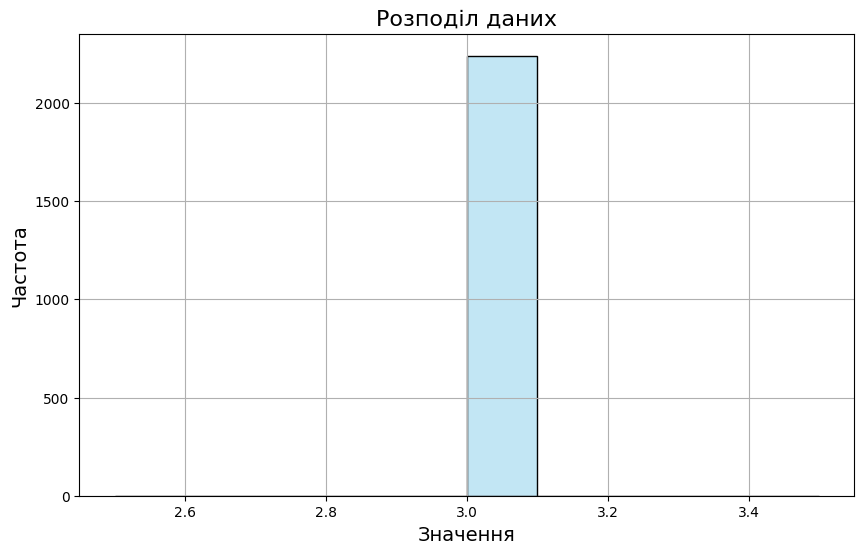

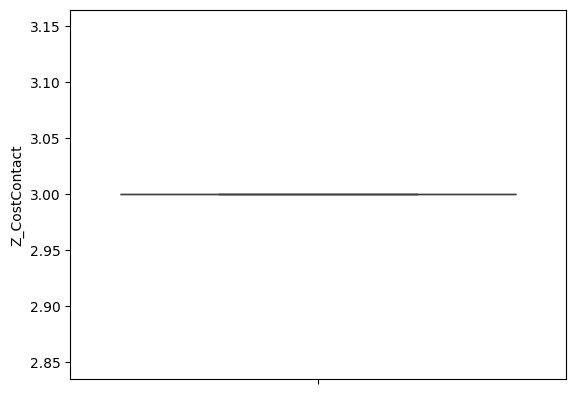

Середнє значення: 11.0
Мода: 11
Медіана: 11.0
Персентилі:0.01    11.0
0.25    11.0
0.50    11.0
0.75    11.0
0.99    11.0
1.00    11.0
Name: Z_Revenue, dtype: float64
Мінімальне:11
Максимальне:11


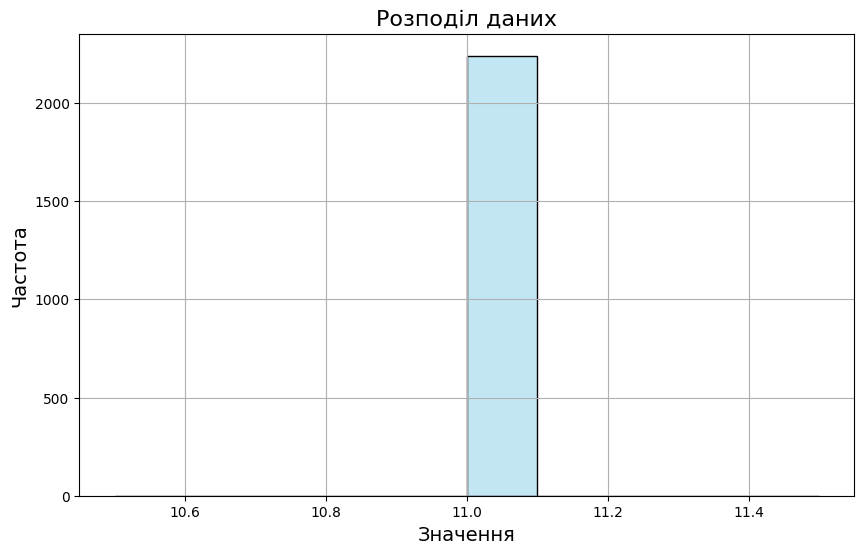

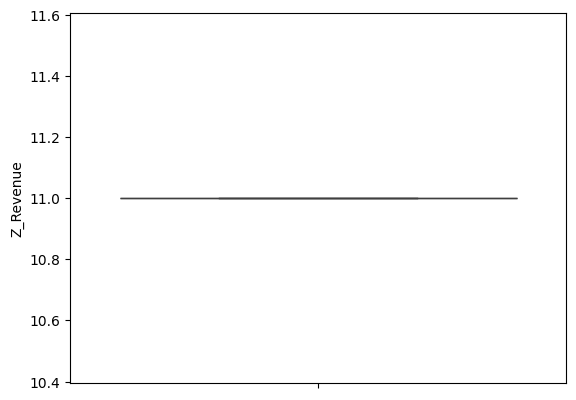

Середнє значення: 0.15
Мода: 0
Медіана: 0.0
Персентилі:0.01    0.0
0.25    0.0
0.50    0.0
0.75    0.0
0.99    1.0
1.00    1.0
Name: Response, dtype: float64
Мінімальне:0
Максимальне:1


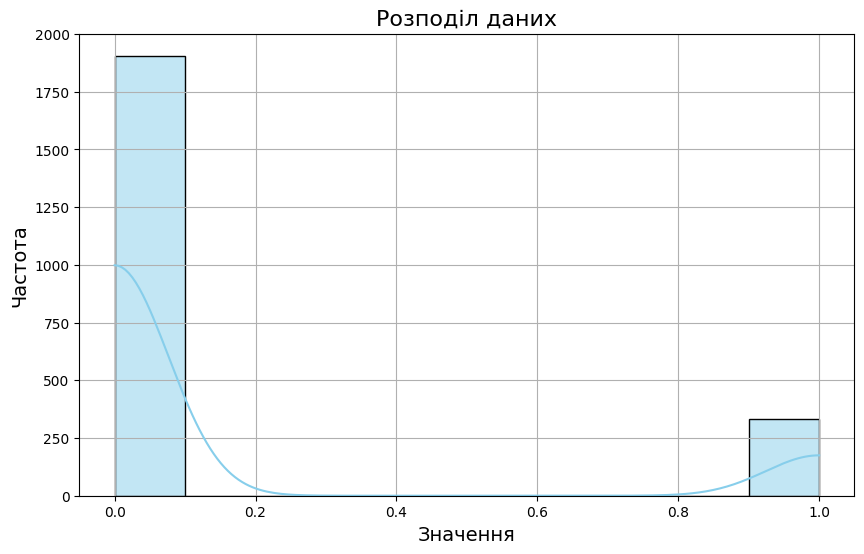

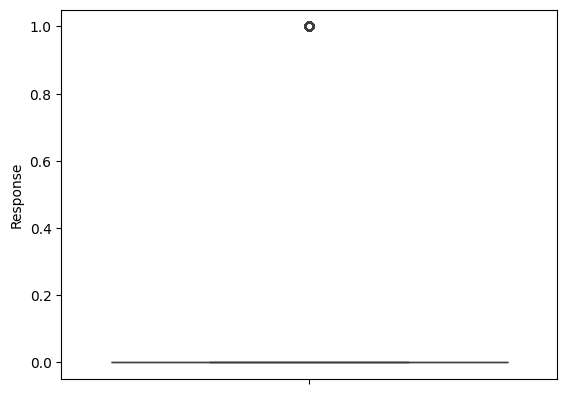

Середнє значення: 353.58
Мода: 667
Медіана: 355.5
Персентилі:0.01      7.00
0.25    180.75
0.50    355.50
0.75    529.00
0.99    691.00
1.00    699.00
Name: Days_lifetime, dtype: float64
Мінімальне:0
Максимальне:699


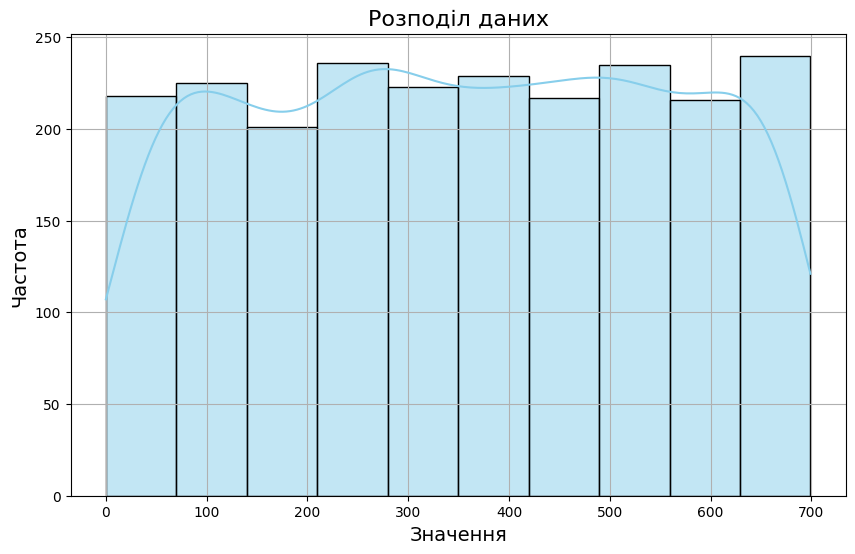

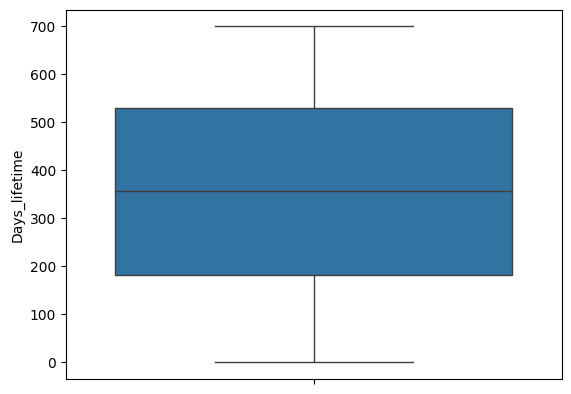

Середнє значення: 46.19
Мода: 39
Медіана: 45.0
Персентилі:0.01     23.0
0.25     38.0
0.50     45.0
0.75     56.0
0.99     70.0
1.00    122.0
Name: Age_client, dtype: float64
Мінімальне:19
Максимальне:122


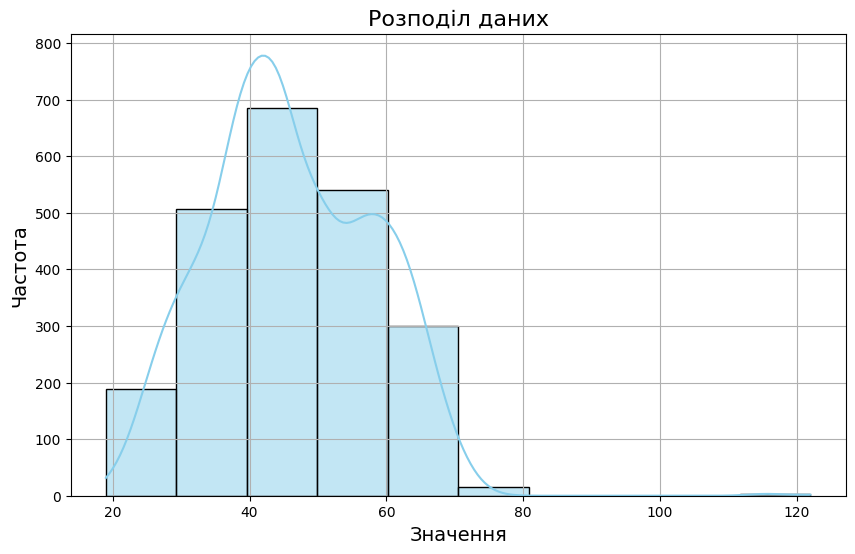

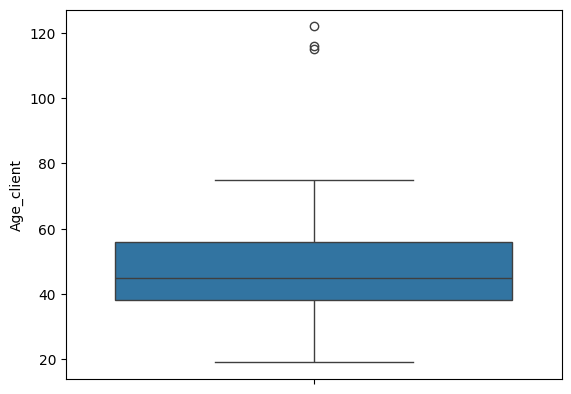

In [ ]:
descr_num_cols(df)

##Формування попередніх висновків

###Автоматичний проект звіту

Форомуємо висновки по колонкам, на основі аналізу на викиди на розподіл даних.
За допомогою функції сформуємо проект звіту, а потім відредагуємо/доповнимо

In [ ]:
zvit_columns = creat_zvit_num(df)
zvit_columns

,Назва колонки,Викиди,Розподіл_даних,План_дій,Висновки
0,Year_Birth,Викиди від 1893 до 1932.0,"Ненормальний (Лівостороння, Середня асиметрія)",Розглянути видалення або заміну викидів,NaN
1,Income,Викиди від 118350.5 до 666666.0,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
2,Kidhome,Немає викидів,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути трансформацію (Логарифмічне або ква...,NaN
3,Teenhome,Немає викидів,"Ненормальний (Правостороння, Середня асиметрія)",Розглянути трансформацію (Логарифмічне або ква...,NaN
4,Recency,Немає викидів,"Ненормальний (Лівостороння, Слабка асиметрія)",Розглянути трансформацію (Квадрат або інверсія...,NaN
5,MntWines,Викиди від 1225.0 до 1493,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
6,MntFruits,Викиди від 81.0 до 199,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
7,MntMeatProducts,Викиди від 556.0 до 1725,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
8,MntFishProducts,Викиди від 120.5 до 259,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
9,MntSweetProducts,Викиди від 81.0 до 263,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN


####Проміжні висновки
- Виключити з датасету колонки 'Z_CostContact', бо єдиними значенням, яким заповнено всю колонку є "3", також в описі датасету на Kaggle  відсутня дана колонка;
- Виключити з датасету колонки 'Z_Revenue', бо єдиними значенням, яким заповнено всю колонку є "11", також в описі датасету на Kaggle  відсутня дана колонка.


**Редагуємо звіт по числовим колонкам**


*Year_birth*

Викидами є значення менші 1932.

In [ ]:
df.Year_Birth[df['Year_Birth']<=1932].value_counts()

,count
Year_Birth,
1900,1
1893,1
1899,1


In [ ]:
zvit_columns.loc[0, 'Висновки'] ='Викиди становлять 3 рядки. Ці рядки можемо видалити'

*Age_clien*

Після видалення викидів з колонки 'Year_birth'. В даній колонці теж не буде викидів

In [ ]:
zvit_columns.loc[26, 'Висновки'] ="Після видалення викидів з колонки 'Year_birth'. В даній колонці теж не буде викидів"

*Kidhome, Teenhome*

В обох колонках нерівномірний розподіл за кількістю 0, 1 та 2. Хочу перевірити чи включає Kidhome (діти) також і підлітків.

In [ ]:
df_minor = df[(df['Kidhome']>0) | (df['Teenhome']>0)]
df_minor.shape

(1602, 31)

In [ ]:
df_minor.Kidhome.value_counts()

,count
Kidhome,
1,899
0,655
2,48


In [ ]:
df_minor.Teenhome.value_counts()

,count
Teenhome,
1,1030
0,520
2,52


Гіпотеза не підтвердилась, оскільки є дані, де 0 дітей, але є підлітки. Вважаю, що датасет можна збагатити даними, додававши колонку 'Minor', обрахувавши кількість неповнолітніх в домогосподарстві.

In [ ]:
#Kidhome
zvit_columns.loc[2, 'Висновки'] ='Нерівномірний розподіл класів. Врахувати при масштабуванні. Дані не включають інформацію про підлітків'

#Teenhome
zvit_columns.loc[3, 'Висновки'] ='Нерівномірний розподіл класів. Врахувати при масштабуванні. Дані не включають інформацію про підлітків'

*Recency*
Кількість днів з моменту останньої покупки клієнта

In [ ]:
zvit_columns.loc[4, 'Висновки'] ='У нас максимальна кількість днів становить 100 днів.'

*Група даних по витратах за категоріями*

Розподіл даних є подібний за різними групами товарів. Викиди становлять значну частку. Пізніше застосовувати логістичне масштабування. Дані за цими колонками потребують додаткових досліджень.


In [ ]:
mnt_cols = [5, 6, 7, 8, 9, 10]
for col in mnt_cols:
    zvit_columns.loc[col, 'Висновки'] ='Викиди становлять значну частку. Пізніше застосовувати логістичне масштабування. Дані за цими колонками потребують додаткових досліджень.'

*Група даних про взаємодію з компанією*

Розподіл даних є подібний за різними групами товарів. Викиди становлять значну частку. Дані за цими колонками потребують додаткових досліджень.

In [ ]:
num_cols = [11, 12, 13, 14, 15]
for col in num_cols:
    zvit_columns.loc[col, 'Висновки'] ='Викиди становлять значну частку. Дані за цими колонками потребують додаткових досліджень.'

*Група даних по відгуку клієнтів на акції*

Незбалансовані класи по користуванню акційними пропозиціями. Потребує додаткового аналізу.

In [ ]:
accept_cols = [16, 17, 18, 19, 20, 24]
for col in accept_cols:
    zvit_columns.loc[col, 'Висновки'] ='Незбалансовані класи по користуванню акційними пропозиціями. Потребує додаткового аналізу.'

*Income*

In [ ]:
#викиди
df[df['Income'] >= 118350.5].Income.value_counts()

,count
Income,
157243.0,1
162397.0,1
153924.0,1
160803.0,1
157733.0,1
157146.0,1
156924.0,1
666666.0,1


In [ ]:
#пропущені значення
df['Income_not_filled'] = df.Income.isna()
df.Income = df.Income.fillna(-1)

Відсутні значення становили 1.07% даних по одній з колонок і їх було замінено на -1, та створено колонку з відміткою про внесення змін.
Рядки з викидами по колонці Income можемо виділити пізніше в окреми датафрейм і окремо проаналізувати поведінку покупців з високим доходом.
Для кластеризації рядки з викидами виключемо з датасету.

In [ ]:
zvit_columns.loc[1, 'Висновки'] ='Відсутні значення становили 1.07% даних по одній з колонок і їх було замінено на -1, та створено колонку з відміткою про внесення змін. Рядки з викидами по колонці Income можемо виділити пізніше в окреми датафрейм і окремо проаналізувати поведінку покупців з високим доходом. Для кластеризації рядки з викидами виключемо з датасету.'

*Z_CostContact, Z_Revenue*

Виключити з датасету колонку 'Z_CostContact', бо єдиними значенням, яким заповнено всю колонку є "3", також в описі датасету на Kaggle відсутня дана колонка.

Виключити з датасету колонки 'Z_Revenue', бо єдиними значенням, яким заповнено всю колонку є "11", також в описі датасету на Kaggle відсутня дана колонка.

In [ ]:
zvit_columns.loc[22, 'Висновки'] ="Виключити з датасету колонку 'Z_CostContact', бо єдиними значенням, яким заповнено всю колонку є '3', також в описі датасету на Kaggle відсутня дана колонка."
zvit_columns.loc[23, 'Висновки'] ="Виключити з датасету колонки 'Z_Revenue', бо єдиними значенням, яким заповнено всю колонку є '11', також в описі датасету на Kaggle відсутня дана колонка."

*Complain*

Дані про скарги клієнтів за останні 2 роки. Нерівномірний розподіл класів, що є логічним для такого роду даних. Нічого не робимо.

In [ ]:
zvit_columns.loc[21, 'Висновки'] ="Дані про скарги клієнтів за останні 2 роки. Нерівномірний розподіл класів, що є логічним для такого роду даних. Нічого не робимо."

### Відредагований звіт

In [ ]:
zvit_columns

,Назва колонки,Викиди,Розподіл_даних,План_дій,Висновки
0,Year_Birth,Викиди від 1893 до 1932.0,"Ненормальний (Лівостороння, Середня асиметрія)",Розглянути видалення або заміну викидів,Викиди становлять 3 рядки. Ці рядки можемо вид...
1,Income,Викиди від 118350.5 до 666666.0,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,Відсутні значення становили 1.07% даних по одн...
2,Kidhome,Немає викидів,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути трансформацію (Логарифмічне або ква...,Нерівномірний розподіл класів. Врахувати при м...
3,Teenhome,Немає викидів,"Ненормальний (Правостороння, Середня асиметрія)",Розглянути трансформацію (Логарифмічне або ква...,Нерівномірний розподіл класів. Врахувати при м...
4,Recency,Немає викидів,"Ненормальний (Лівостороння, Слабка асиметрія)",Розглянути трансформацію (Квадрат або інверсія...,У нас максимальна кількість днів становить 100...
5,MntWines,Викиди від 1225.0 до 1493,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,Викиди становлять значну частку. Пізніше засто...
6,MntFruits,Викиди від 81.0 до 199,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,Викиди становлять значну частку. Пізніше засто...
7,MntMeatProducts,Викиди від 556.0 до 1725,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,Викиди становлять значну частку. Пізніше засто...
8,MntFishProducts,Викиди від 120.5 до 259,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,Викиди становлять значну частку. Пізніше засто...
9,MntSweetProducts,Викиди від 81.0 до 263,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,Викиди становлять значну частку. Пізніше засто...


**Видаляємо стовпці та викиди, щодо яких було прийнято таке рішення**

In [ ]:
df = df.drop(["Z_CostContact", "Z_Revenue"], axis=1)

In [ ]:
df = df[df['Year_Birth'] > 1932]

#Загальний аналіз категоріальних даних

In [ ]:
df.select_dtypes(include = "object").columns

Index(['ID', 'Education', 'Marital_Status'], dtype='object')

**Edication**

In [ ]:
df.Education.value_counts(normalize=True)*100

,proportion
Education,
Graduation,50.379973
PhD,21.680823
Master,16.540009
2n Cycle,8.985248
Basic,2.413947


Для кращого розуміння даних зробимо візуалізацію

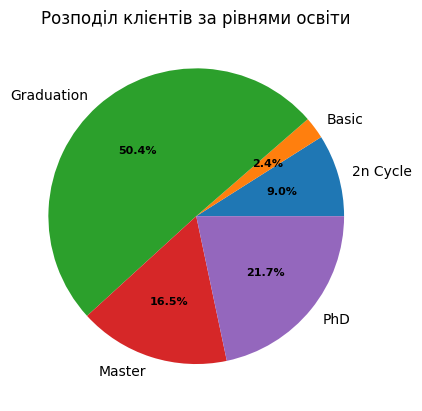

In [ ]:
labels = df['Education'].value_counts().sort_index().index
sizes = df['Education'].value_counts().sort_index().values

# Створення кругової діаграми
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# Налаштування розміру та шрифту відсотків
plt.setp(autotexts, size=8, weight="bold")

# Додавання заголовка
plt.title("Розподіл клієнтів за рівнями освіти")

plt.show()

**Висновки:**
1. Припускаю, що  система освіти в регіоні, де збиралися дані: Basic - Graduation - 2nd Cycle - Master - PhD.
2. Більшість клієнтів мають освіту від бакалавра і вище.

**Marital_Status**

In [ ]:
df.Marital_Status.value_counts(normalize=True)*100

,proportion
Marital_Status,
Married,38.623156
Together,25.882879
Single,21.412606
Divorced,10.326330
Widow,3.442110
Alone,0.134108
Absurd,0.089405
YOLO,0.089405


In [ ]:
#зменшуємо кількість категорій, які мало представлені і є можливість логічно групувати
marital_status_map ={'Alone': 'Single', 'Married': 'Married', 'Together': 'Together', 'Single': 'Single', 'Divorced': 'Divorced', 'Widow': 'Widow'}
df['Marital_Status'] = df.Marital_Status.map(marital_status_map).fillna('Else')

In [ ]:
#виводимо розподіл між категоріями після групування
df.Marital_Status.value_counts(normalize=True)*100

,proportion
Marital_Status,
Married,38.623156
Together,25.882879
Single,21.546714
Divorced,10.326330
Widow,3.442110
Else,0.178811


Для кращого розуміння даних зробимо візуалізацію

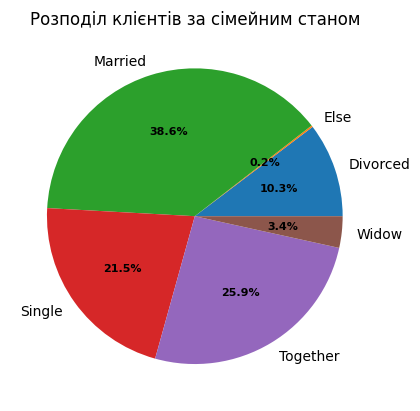

In [ ]:
labels = df['Marital_Status'].value_counts().sort_index().index
sizes = df['Marital_Status'].value_counts().sort_index().values

# Створення кругової діаграми
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# Налаштування розміру та шрифту відсотків
plt.setp(autotexts, size=8, weight="bold")

# Додавання заголовка
plt.title("Розподіл клієнтів за сімейним станом")

plt.show()

###Висновки
1. Одним із етапів підготовки даних колонки 'Edication' щодо рівня освіти перед подачею в модель, буде застосування label encoding;  
2. Одним із етапів підготовки даних колонки 'Marital_Status' щодо сімейного статусу перед подачею в модель, буде застосування словника та заповнення всіх інших категорій - Else.


#Додатковий аналіз за окремими групами даних

##Дані про неповнолітніх

Як раніше було з'ясовано: 2 колонки ('Kidshome' та 'Teenshome') містять інформацію про неповнолітніх членів домогосподарств клієнтів. В даному розділі добавлю в датьфрейм  колонку 'Minor', де буде відображена кількість неповнолітніх у клієнта.
Також проаналізуємояке співвідношення дітей та підлітків в сім'ях з різною кількістю неповнолітніх.

In [ ]:
#додаємо колонку про кількість неповнолітніх (діти+підлітки) у клієнта
df = add_minor(df)

In [ ]:
#додаємо колонку про варіант співвідношення неповнолітніх у клієнта
df = type_minor(df)

In [ ]:
#дані про співвідношення кількості неповнолітніх у клієнта
df.Minor.value_counts(normalize=True)

,proportion
Minor,
1,0.503353
0,0.284756
2,0.188198
3,0.023692


Візуалізуємо дані щодо кількості неповнолітніх у клієнтів

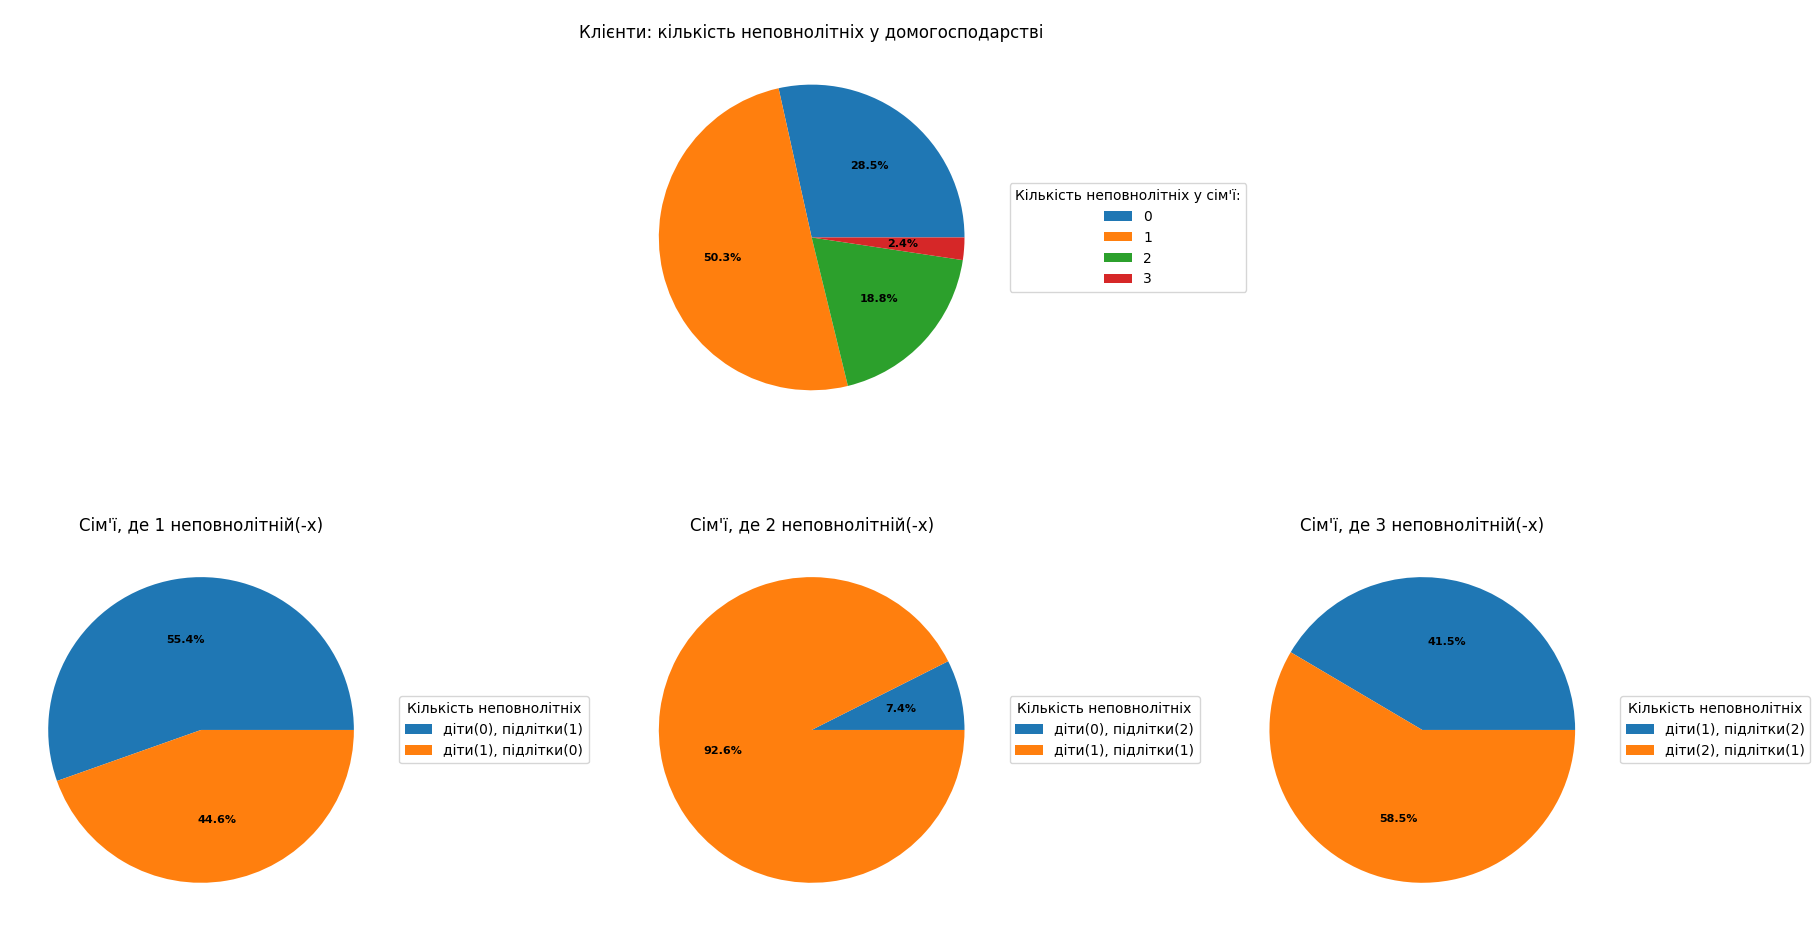

In [ ]:

# Створення сітки підграфіків
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Загальна кругова діаграма
labels = df['Minor'].value_counts().sort_index().index
sizes = df['Minor'].value_counts().sort_index().values
wedges, texts, autotexts = axes[0, 1].pie(sizes, autopct='%1.1f%%')

axes[0, 1].legend(wedges, labels,
                  title="Кількість неповнолітніх у сім'ї:",
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
axes[0, 1].set_title("Клієнти: кількість неповнолітніх у домогосподарстві")

# Індивідуальні кругові діаграми
for i, minor_count in enumerate([1, 2, 3]):
    labels = df[df['Minor'] == minor_count].Type_minor.value_counts().sort_index().index
    sizes = df[df['Minor'] == minor_count].Type_minor.value_counts().sort_index().values

    wedges, texts, autotexts = axes[1, i].pie(sizes, autopct='%1.1f%%')

    axes[1, i].legend(wedges, labels,
                      title=f"Кількість неповнолітніх",
                      loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")
    axes[1, i].set_title(f"Сім'ї, де {minor_count} неповнолітній(-х)")

axes[0, 0].axis('off')
axes[0, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df[(df['Minor']>1) & (df['Kidhome']>0)].Teenhome.value_counts(normalize=True)*100

,proportion
Teenhome,
1,91.216216
2,4.954955
0,3.828829


In [ ]:
df[(df['Minor']>1) & (df['Teenhome']>0)].Kidhome.value_counts(normalize=True)*100

,proportion
Kidhome,
1,86.652079
2,6.783370
0,6.564551


Візуалізуємо дані

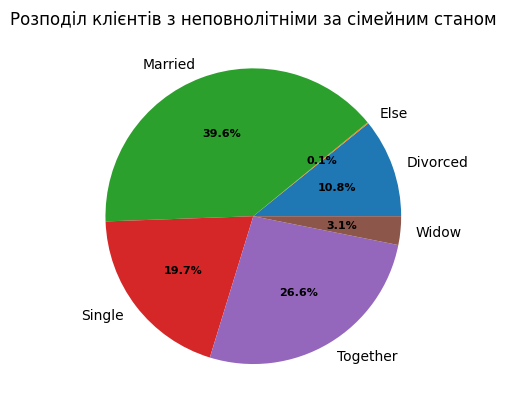

In [ ]:
labels = df[df['Minor']>0].Marital_Status.value_counts().sort_index().index
sizes = df[df['Minor']>0].Marital_Status.value_counts().sort_index().values

# Створення кругової діаграми
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# Налаштування розміру та шрифту відсотків
plt.setp(autotexts, size=8, weight="bold")

# Додавання заголовка
plt.title("Розподіл клієнтів з неповнолітніми за сімейним станом")

plt.show()

###Висновки
1. У 70% клієнтів є неповнолітні в сім'ї.
2. Якщо в сімї більше одного неповнолітнього, то більше 86%, що клієнту можна пропонувати товари для обох вікових груп неповнолітніх.
3. Основний датасет слід збагачувати даними про кількість неповнолітніх в сім'ї і експерементувати з доданням співвідношення дітей та підлітків в сім'ї

##Дані по витратам на певні групи товарів

In [ ]:
#додаємо колонку з загальними витратами по категоріям товарів
df = add_mnt (df)

Візуалізуємо дані

In [ ]:
#підготуємо дані до візуалізації
df_mnt = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].aggregate('sum')
df_mnt

,0
MntWines,680038
MntFruits,58767
MntMeatProducts,373393
MntFishProducts,83939
MntSweetProducts,60553
MntGoldProds,98358


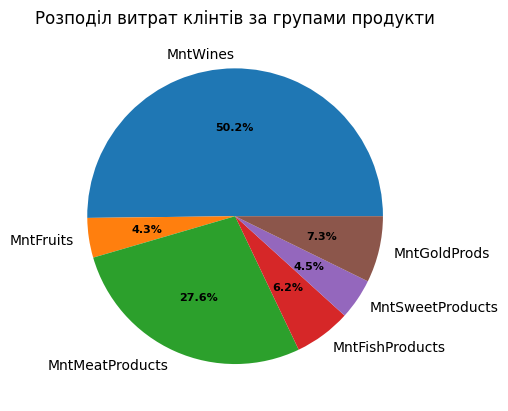

In [ ]:
data = {
    'Category': ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
    'Amount': [680038, 58767, 373393, 83939, 60553, 98358]}
df_mnt = pd.DataFrame(data)

labels = df_mnt['Category']
sizes = df_mnt['Amount']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.setp(autotexts, size=8, weight="bold")

plt.title("Розподіл витрат клінтів за групами продукти")

plt.show()

Можемо розглянути, чи у нас клієнт купляє лише певну категорію товарів.

In [ ]:
#додаємо колонку для визначення в скількох категоріях купляє у нас клієнт та який розподіл витрати за категоріями товарів.Всього датасет виділяє 6 категорій.
df = mnt_ads(df)


In [ ]:
#можемо подивитись розподіл даних в кількості категорій, які клієнт у нас придбав
df.Mnt_count.value_counts(normalize=True).sort_index()

,proportion
Mnt_count,
2,0.005364
3,0.070183
4,0.060796
5,0.216808
6,0.646848


In [ ]:
#який розподіл витрати за категоріями товарів
df.Mnt_count_list.value_counts(normalize=True).sort_index()

,proportion
Mnt_count_list,
"[0, 0, 0, 1, 1, 1]",0.000447
"[0, 0, 1, 1, 1, 1]",0.001788
"[0, 1, 1, 1, 0, 1]",0.000447
"[0, 1, 1, 1, 1, 1]",0.003129
"[1, 0, 1, 0, 0, 0]",0.005364
"[1, 0, 1, 0, 0, 1]",0.064819
"[1, 0, 1, 0, 1, 0]",0.000894
"[1, 0, 1, 0, 1, 1]",0.014752
"[1, 0, 1, 1, 0, 0]",0.001341


###Висновки
1. 64% клієнтів купляють у нас товари у всіх категоріях, а також 21% клієнтів придбають товари у 5 категоріях з шести.
2. З аналізу даних з колонки 'Mnt_count_list' можемо побачити, що відсутні переважаючі набори категорій (окрім 6 категорій з шести).
3. Найбільші продажи у компанії в категорії 'Wines'.
4. Додавання колонки 'Mnt' та 'Mnt_count' є доцільним. Пізніше буде на її базі сторено колонку сесередній чек покупця.

##Дані по акціям компанії

Відповідно до опису даних, наступні колонки містять дані цієї групи:

- `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
- `AcceptedCmp1`: 1, якщо клієнт прийняв пропозицію у першій кампанії, 0 - якщо ні
- `AcceptedCmp2`: 1, якщо клієнт прийняв пропозицію у другій кампанії, 0 - якщо ні
- `AcceptedCmp3`: 1, якщо клієнт прийняв пропозицію у третій кампанії, 0 - якщо ні
- `AcceptedCmp4`: 1, якщо клієнт прийняв пропозицію у четвертій кампанії, 0 - якщо ні
- `AcceptedCmp5`: 1, якщо клієнт прийняв пропозицію у п'ятій кампанії, 0 - якщо ні
- `Response`: 1, якщо клієнт прийняв пропозицію в останній кампанії, 0 - якщо ні



In [ ]:
result_sum = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum().sum()
purchases_sum = df['NumDealsPurchases'].sum()

print(f' Всього прийнято пропозиції по 6 акціям - {result_sum} vs Всього зроблено покупок з використанням знижок - {purchases_sum}.')

 Всього прийнято пропозиції по 6 акціям - 1000 vs Всього зроблено покупок з використанням знижок - 5205.


In [ ]:
result1 = df[df['NumDealsPurchases']== 0][['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].aggregate('sum')
print(f'Не було здійснено покупок при прийнятті пропозиці у одній з компанії у {result1.sum()} випадках')

Не було здійснено покупок при прийнятті пропозиці у одній з компанії у 73 випадках


In [ ]:
#Додамо колонку з кількістю прийнятих пропозицій по кожному клієнту
df['Accept_count']= df['AcceptedCmp1']+ df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

Створімо вибірку з клієнтів, які брали участь в акціях компанії та/або робили покупки з використанням знижок

In [ ]:
df_purchases = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumDealsPurchases', 'Accept_count']]
df_purchases = df_purchases[(df_purchases['AcceptedCmp1']>0)|(df_purchases['AcceptedCmp2']>0)|(df_purchases['AcceptedCmp3']>0)|(df_purchases['AcceptedCmp4']>0)|(df_purchases['AcceptedCmp5']>0)|(df_purchases['Response']>0)|(df_purchases['NumDealsPurchases']>0)|(df_purchases['Accept_count'])]

In [ ]:
df_purchases.describe()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,NumDealsPurchases,Accept_count
count,2218.000000,2218.000000,2218.000000,2218.000000,2218.000000,2218.000000,2218.000000,2218.000000
mean,0.064923,0.013526,0.073490,0.075293,0.073039,0.150586,2.346709,0.450857
std,0.246446,0.115537,0.260997,0.263923,0.260259,0.357726,1.929097,0.893808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,5.000000


В дану вибірку потрапили клієнти, які або приймали пропозицію або придбавали щось із знижкою. Подивимось скільки клієнтів купували із знижкою, але при цьому не приймали пропозицію по акції

In [ ]:
df_purchases[(df_purchases['NumDealsPurchases']>0) & (df_purchases['Accept_count']==0)].shape[0]

1610

Можемо прийти до висновку, що знижки та прийняття пропозицій є різними явищами.

Поглянемо який розподіл клієнтів за кількістю прийнятих пропозицій від компанії

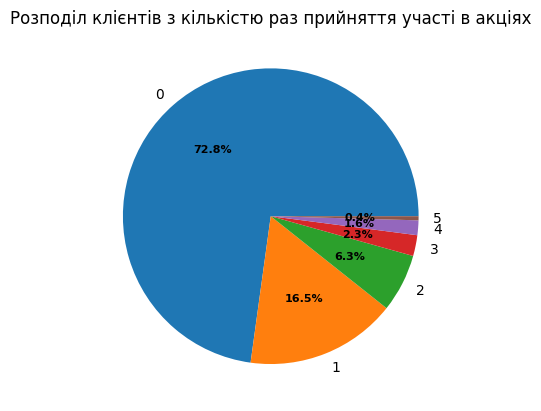

In [ ]:
labels = df.Accept_count.value_counts().sort_index().index
sizes = df.Accept_count.value_counts().sort_index().values

# Створення кругової діаграми
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# Налаштування розміру та шрифту відсотків
plt.setp(autotexts, size=8, weight="bold")

# Додавання заголовка
plt.title("Розподіл клієнтів з кількістю раз прийняття участі в акціях")

plt.show()

Як можемо бачити, 72.6% вибірки робили покупки із знижками, але при цьому не  приймали пропозицію у жодній з 5 компаній.

In [ ]:
a = df[(df['Accept_count']==0)&(df['NumDealsPurchases']==0)].shape[0]
print(f'Кількість клієнтів, які не приймали пропозиції та не робили покупки із знижками {a}, що становить {round((a/df.shape[0]),2)}% від всіх клієнтів')

Кількість клієнтів, які не приймали пропозиції та не робили покупки із знижками 19, що становить 0.01% від всіх клієнтів


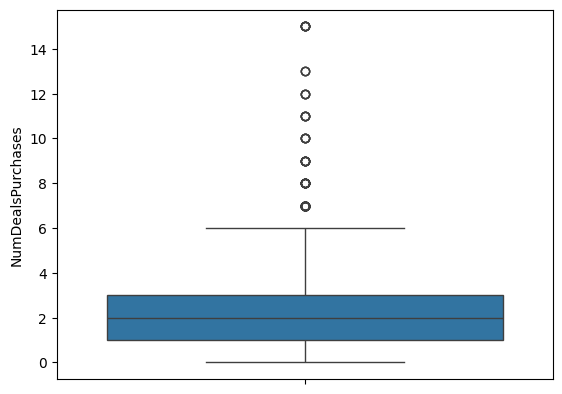

In [ ]:
col_n = df['NumDealsPurchases']
sns.boxplot(col_n)
plt.show()


In [ ]:
col = 'NumDealsPurchases'
print(f'Кількість записів, які є викидами (>6) за колонкою {col}, {df[df[col]>=6].shape[0]}, що становить {round((df[df[col]>=6].shape[0]/df.shape[0]),2)}% від всіх клієнтів, і {round((df[df[col]>=6].shape[0]/df[df[col]>=1].shape[0]),2)}% від клієнтів, що придбавали товари зі знижкою')

Кількість записів, які є викидами (>6) за колонкою NumDealsPurchases, 147, що становить 0.07% від всіх клієнтів, і 0.07% від клієнтів, що придбавали товари зі знижкою


###Висновки
1. Кількість записів, які є викидами (>6) за колонкою NumDealsPurchases, 147, що становить 0.07% від всіх клієнтів, і 0.07% від клієнтів, що придбавали товари зі знижкою.
2. Лише менше 1 відсотка клієнтів не скористалися знижками або пропозиціями компанії.


##Дані по взаємодії з компанією

**Взаємодія з компанією:**
- `NumWebPurchases`: Кількість покупок, зроблених через вебсайт компанії
- `NumCatalogPurchases`: Кількість покупок, зроблених за каталогом
- `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
- `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць

Припускаю, що всі вказані дані зібрані за аналогічний період що і витрати за групами товару. Тому для збагачення даних добавимо колонку 'Середній чек'



In [ ]:
#агрегуємо в колонку про кількість покупок покупки зроблені через різні канали
df['Num_purchases'] = df['NumWebPurchases']+ df['NumWebPurchases'] + df['NumStorePurchases']

In [ ]:
#створюємо колонку з даними про середній чек
df['ASP'] = df['Mnt']/df['Num_purchases']

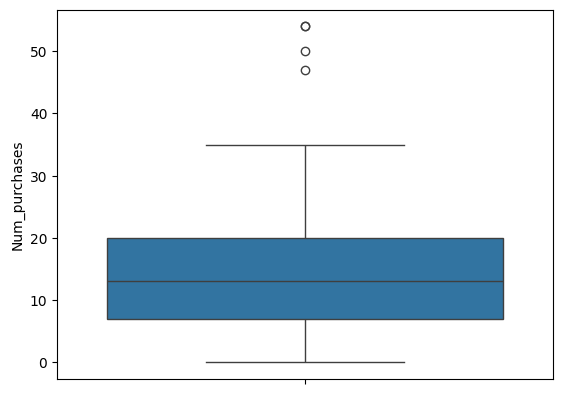

In [ ]:
# візуалізація розподілу даних та викидів за колонкою по кількості покупок
col_n = df['Num_purchases']
sns.boxplot(col_n)
plt.show()

In [ ]:
#аналіз викидів по колонці щодо кількості покупок
col = 'Num_purchases'
m = 35
print(f'Кількість записів, які є викидами (>{m}) за колонкою {col}, {df[df[col]>=m].shape[0]}, що становить {round((df[df[col]>=m].shape[0]/df.shape[0]),2)}% від всіх клієнтів')

Кількість записів, які є викидами (>35) за колонкою Num_purchases, 5, що становить 0.0% від всіх клієнтів


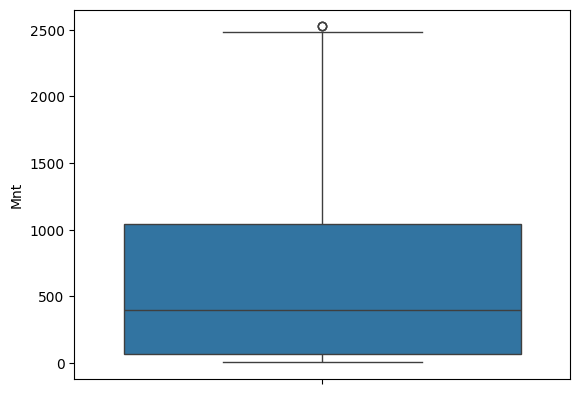

In [ ]:
# візуалізація розподілу даних та викидів за колонкою про загальні витрати
col_n = df['Mnt']
sns.boxplot(col_n)
plt.show()

In [ ]:
#аналіз викидів по колонці щодо загальних витрат
col = 'Mnt'
m = 2500
print(f'Кількість записів, які є викидами (>{m}) за колонкою {col}, {df[df[col]>=m].shape[0]}, що становить {round((df[df[col]>=m].shape[0]/df.shape[0]),2)}% від всіх клієнтів')

Кількість записів, які є викидами (>2500) за колонкою Mnt, 3, що становить 0.0% від всіх клієнтів


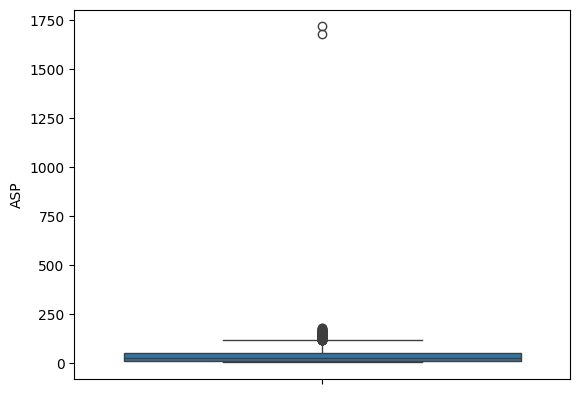

In [ ]:
## візуалізація розподілу даних та викидів за колонкою щодо середнього чеку
col_n = df['ASP']
sns.boxplot(col_n)
plt.show()


In [ ]:
#аналіз викидів по колонці щодо загальних витрат
col = 'ASP'
m = 400
print(f'Кількість записів, які є викидами (>{m}) за колонкою {col}, {df[df[col]>=m].shape[0]}, що становить {round((df[df[col]>=m].shape[0]/df.shape[0]),2)}% від всіх клієнтів')

Кількість записів, які є викидами (>400) за колонкою ASP, 12, що становить 0.01% від всіх клієнтів


#Аналіз за поєднанням даних

Розглянемо як корелюються наявні числові дані

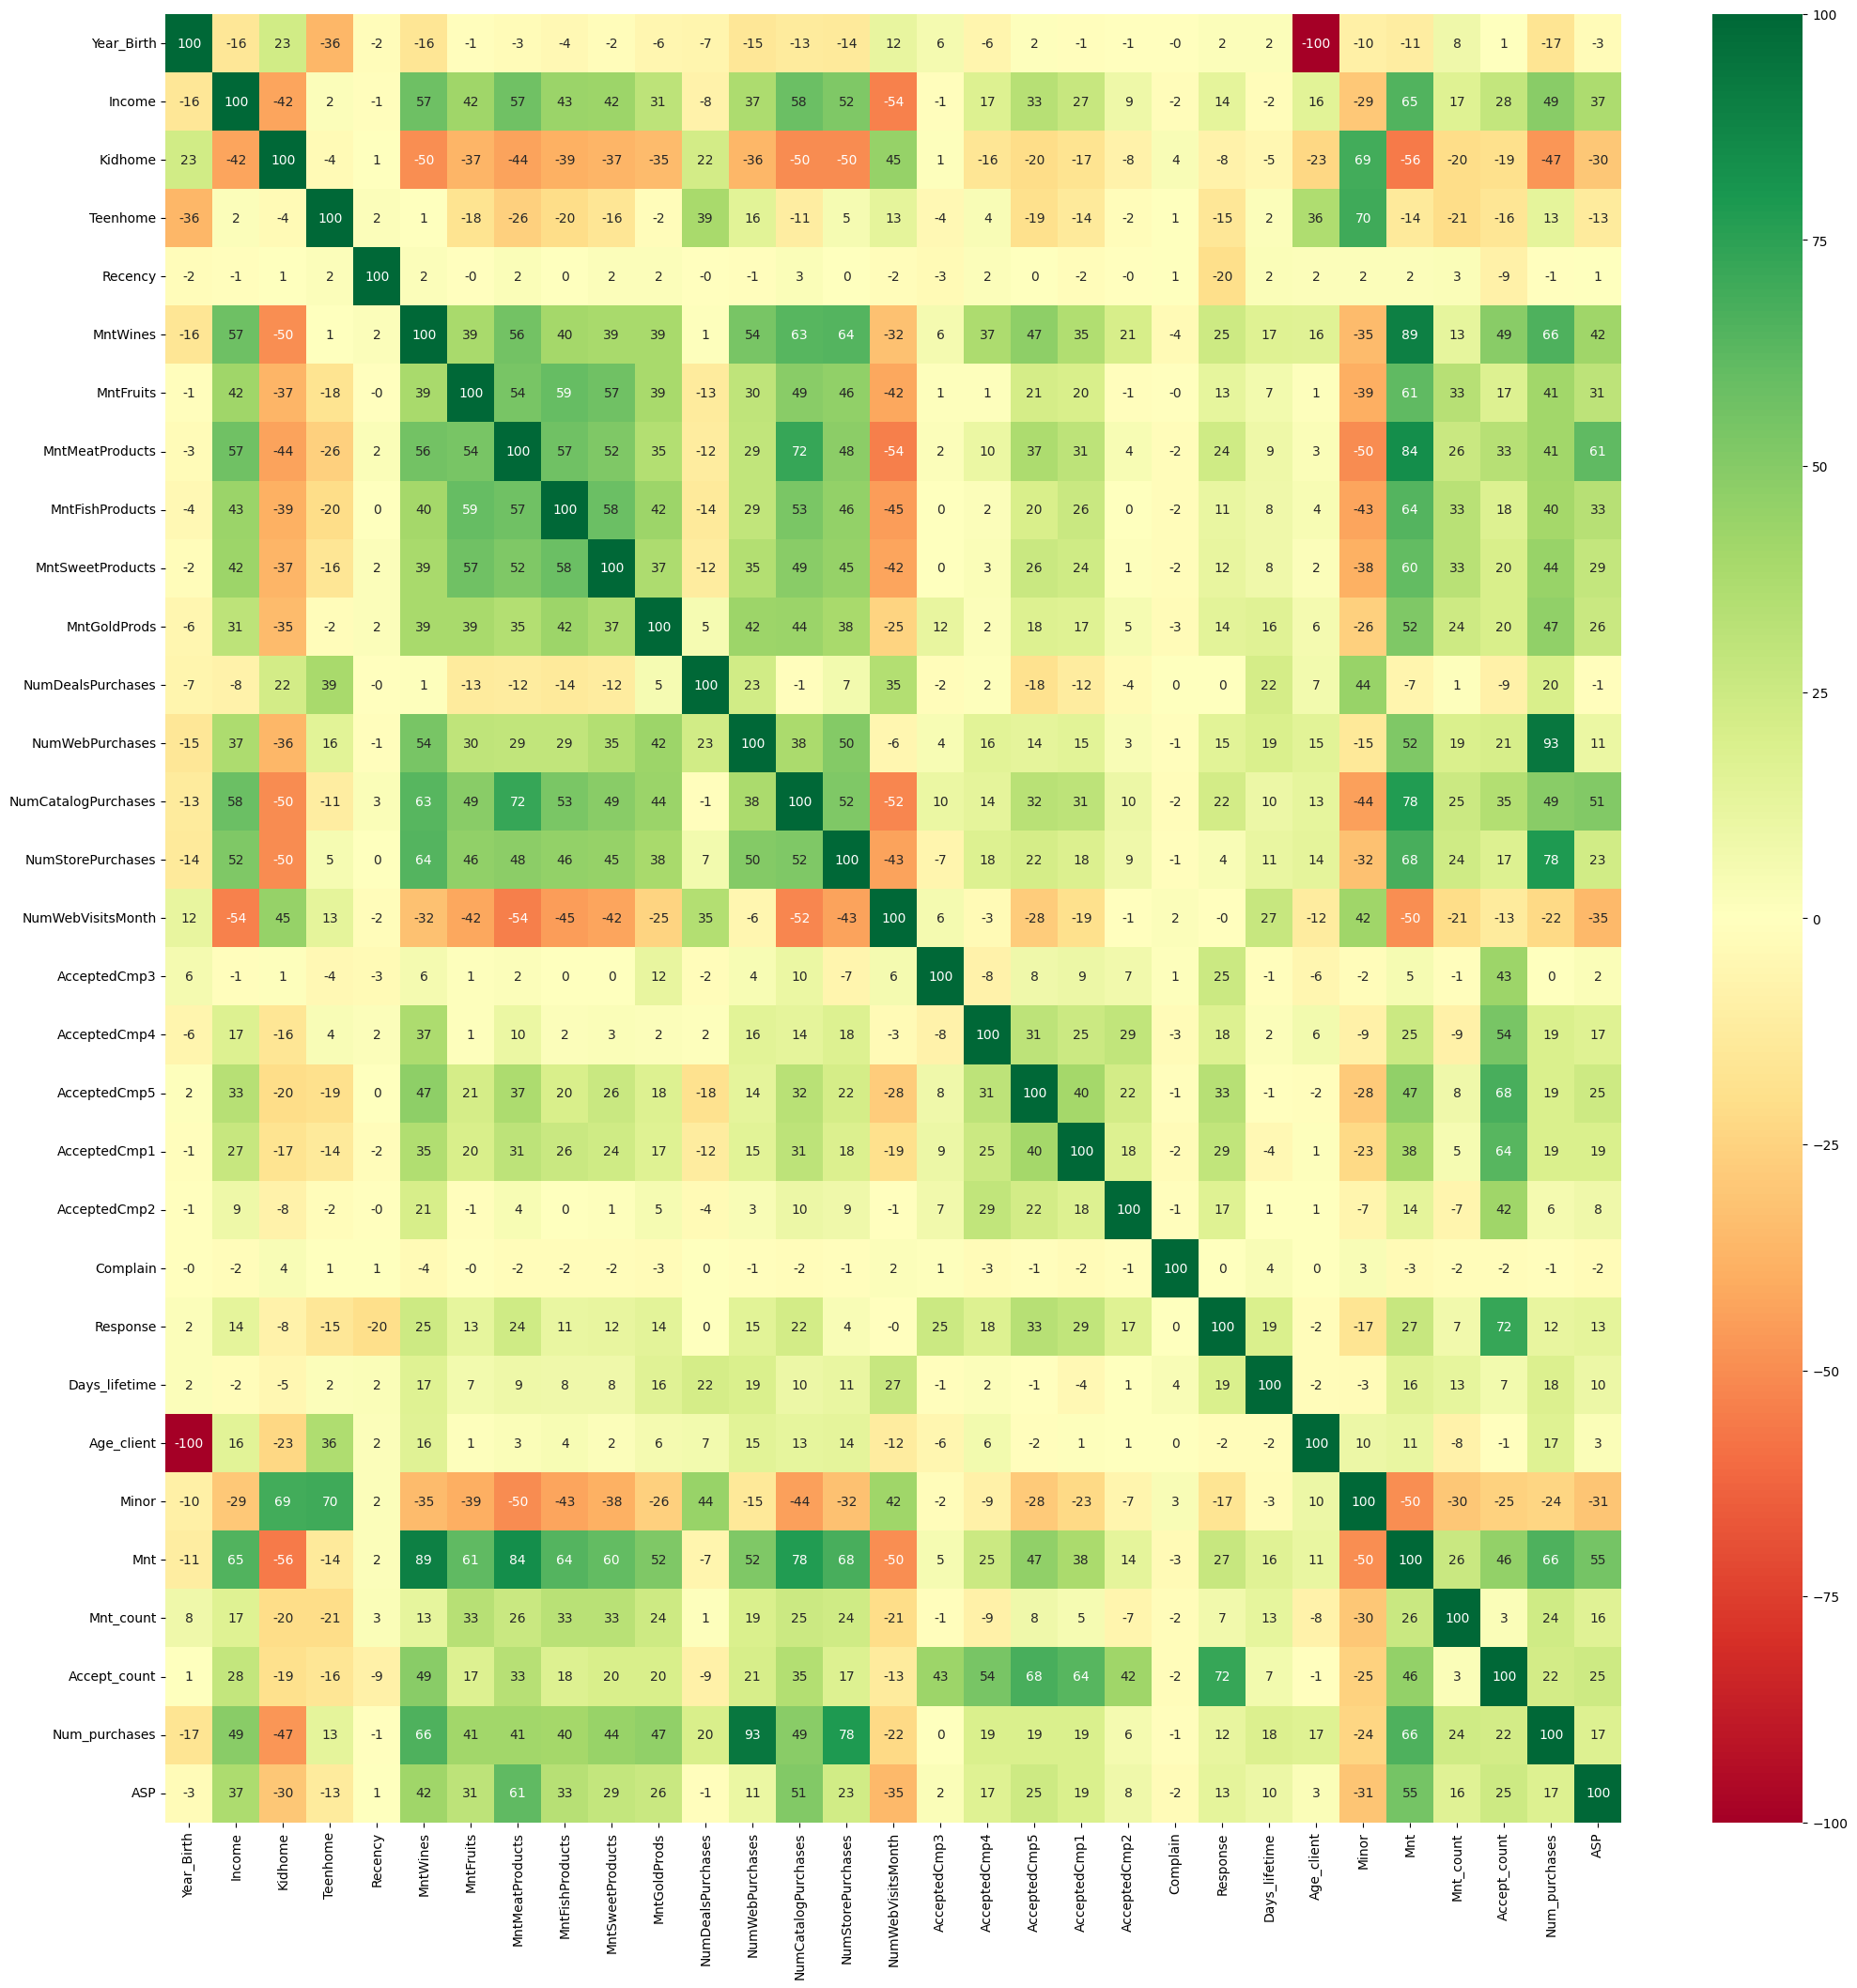

In [ ]:
corr_map (df)

Для спрощення аналізу виведемо кореляційні дані з відсотком кореляції від 50%

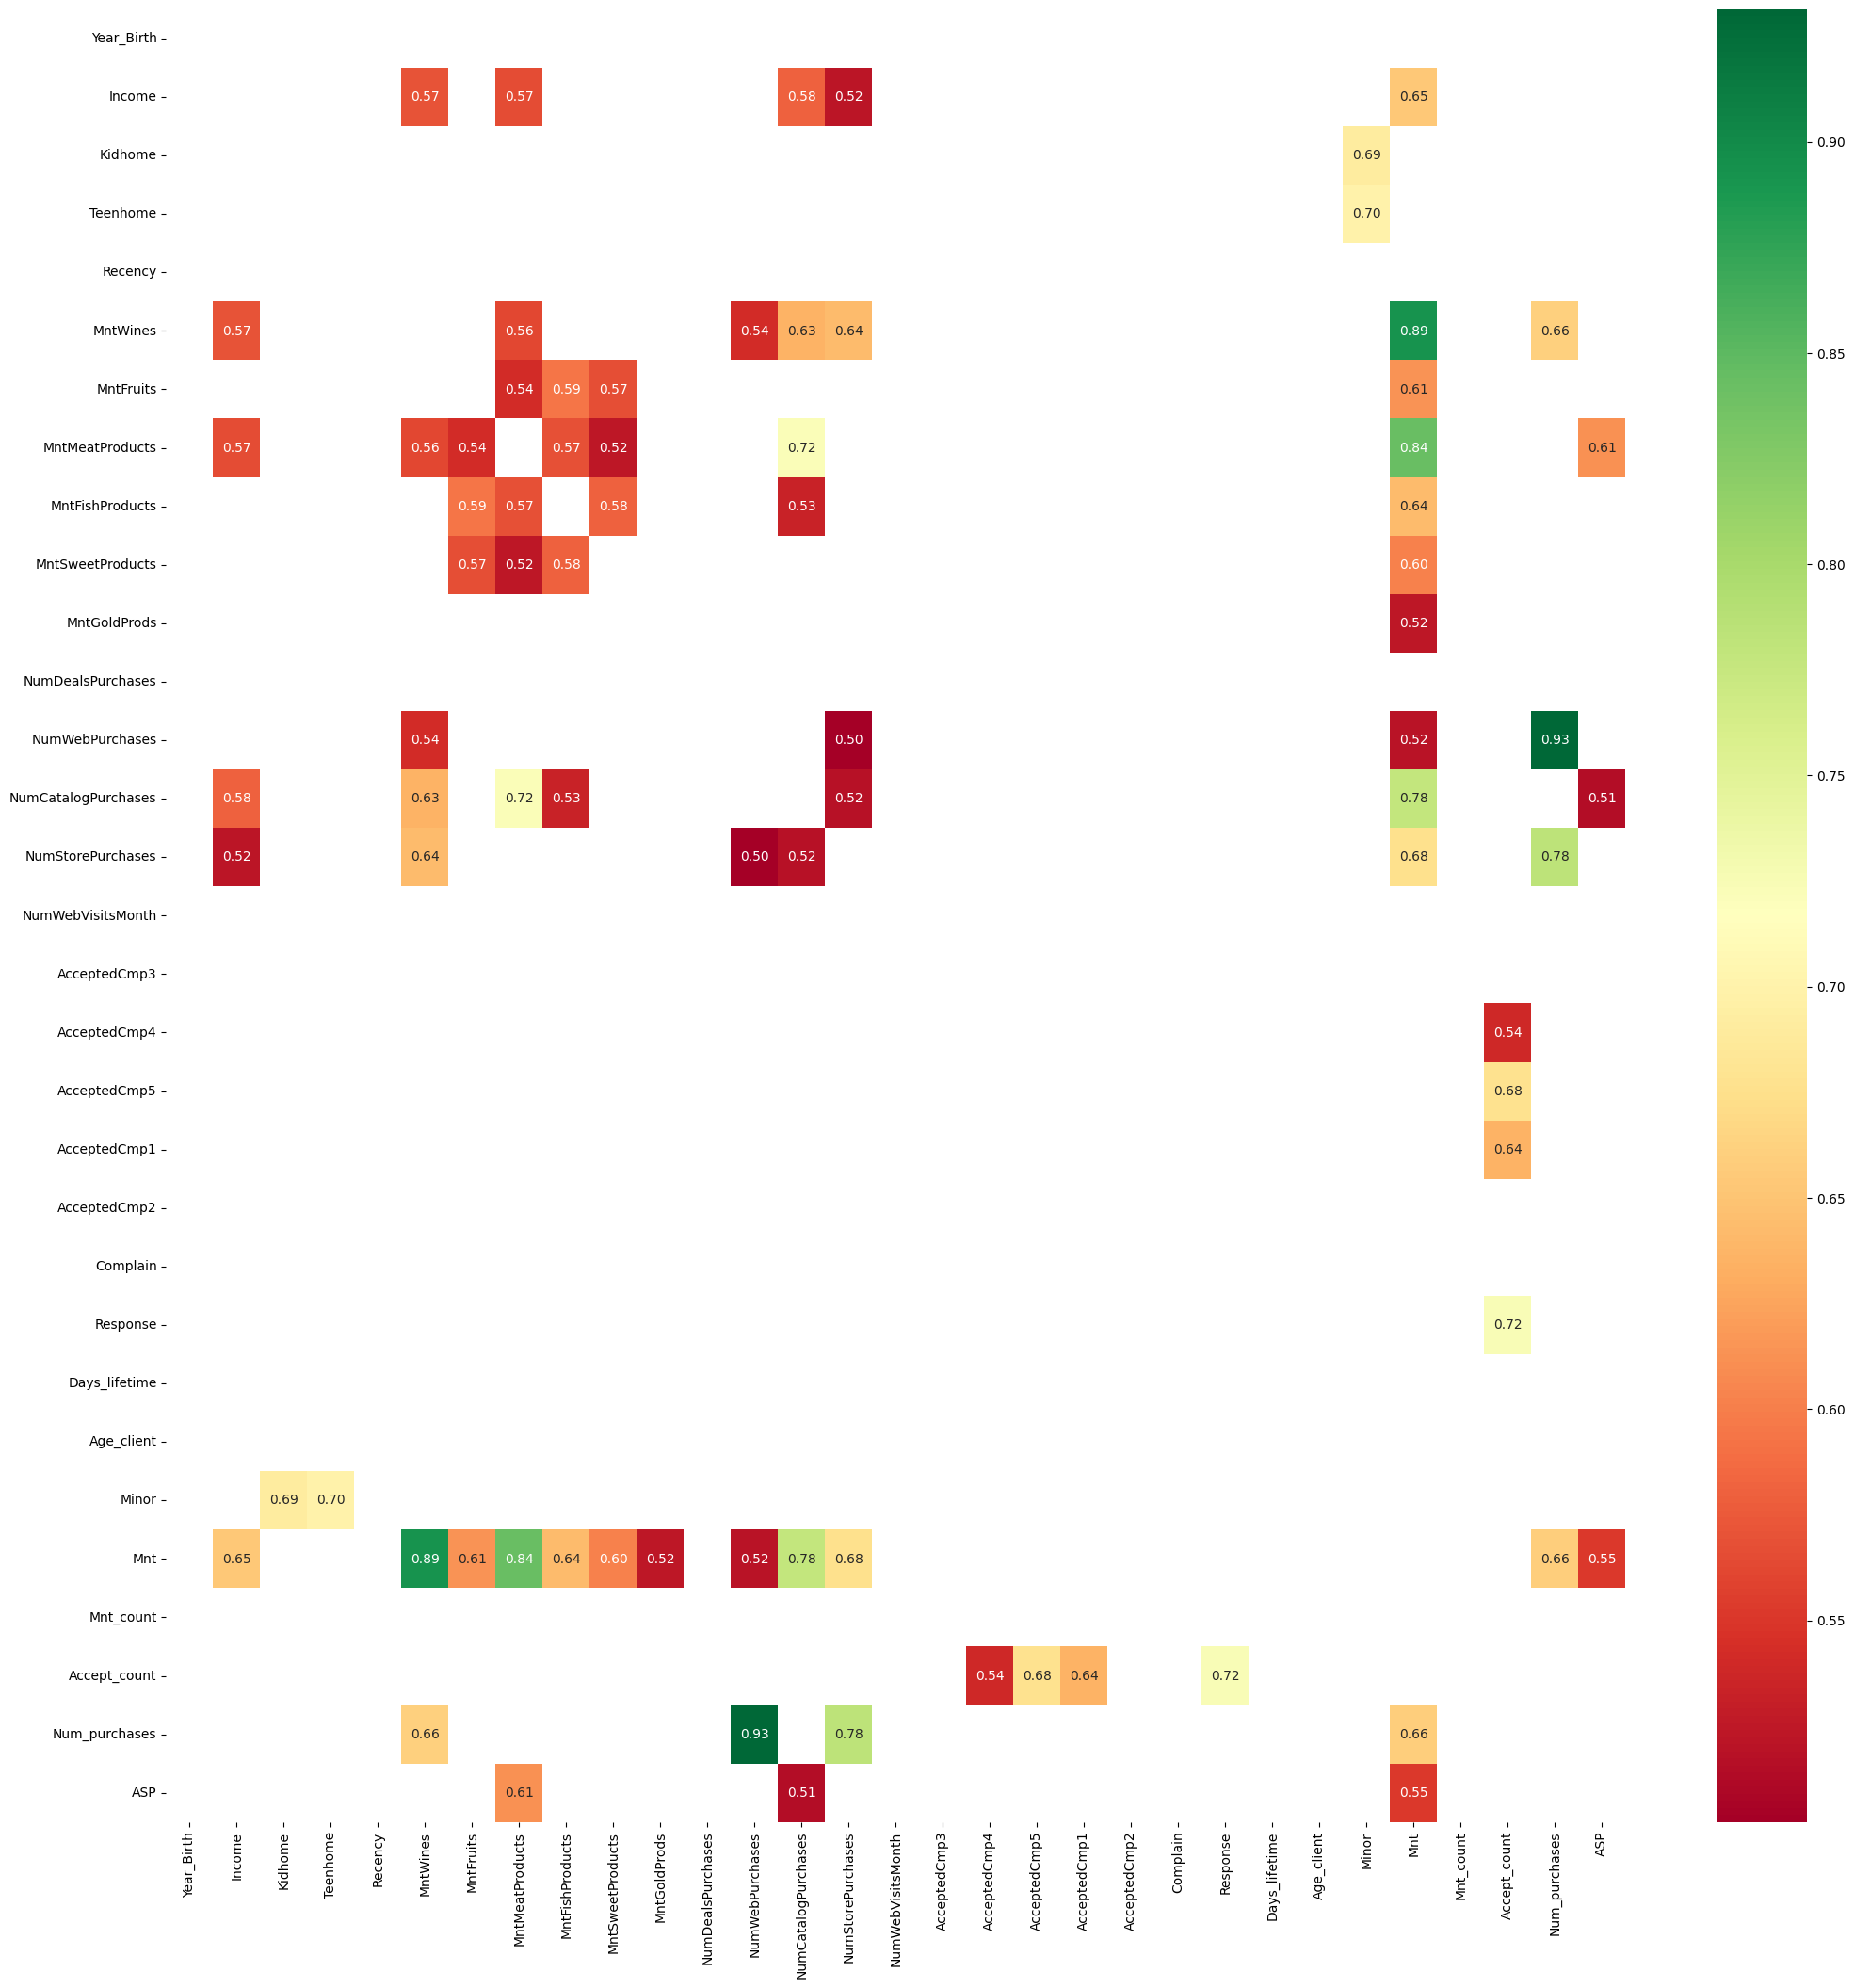

,,0
NumWebPurchases,Num_purchases,0.93
Num_purchases,NumWebPurchases,0.93
Mnt,MntWines,0.89
MntWines,Mnt,0.89
MntMeatProducts,Mnt,0.84
Mnt,MntMeatProducts,0.84
Num_purchases,NumStorePurchases,0.78
NumStorePurchases,Num_purchases,0.78
Mnt,NumCatalogPurchases,0.78
NumCatalogPurchases,Mnt,0.78


In [ ]:
heat_corr (df, 0.50)

Оскільки кожна пара колонок виведена двічі, та є створені нами колонки на базі існуючих, які логічно корелюються, виокремимо пари, які можуть дати нове розуміння даних:
  - NumCatalogPurchases - Mnt	- 0.78
  - MntMeatProducts	- NumCatalogPurchases - 	0.72
  - Accept_count - Response -	0.72
  - Mnt	- NumStorePurchases	- 0.68
  - MntWines	- Num_purchases -	0.66
  - Income	- Mnt	0.65

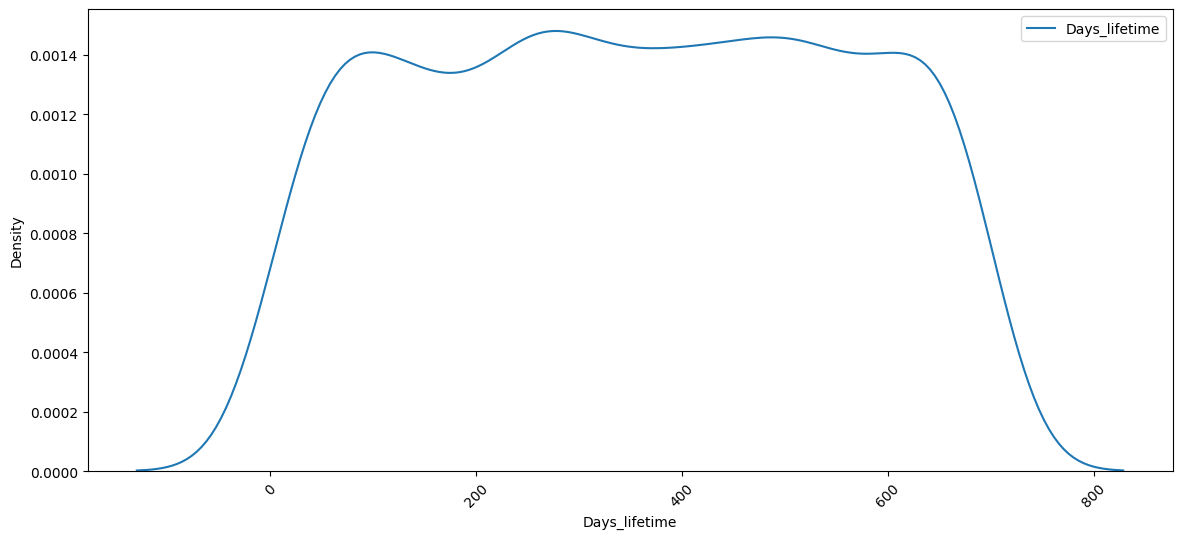

In [ ]:
kde(df, 'Days_lifetime')

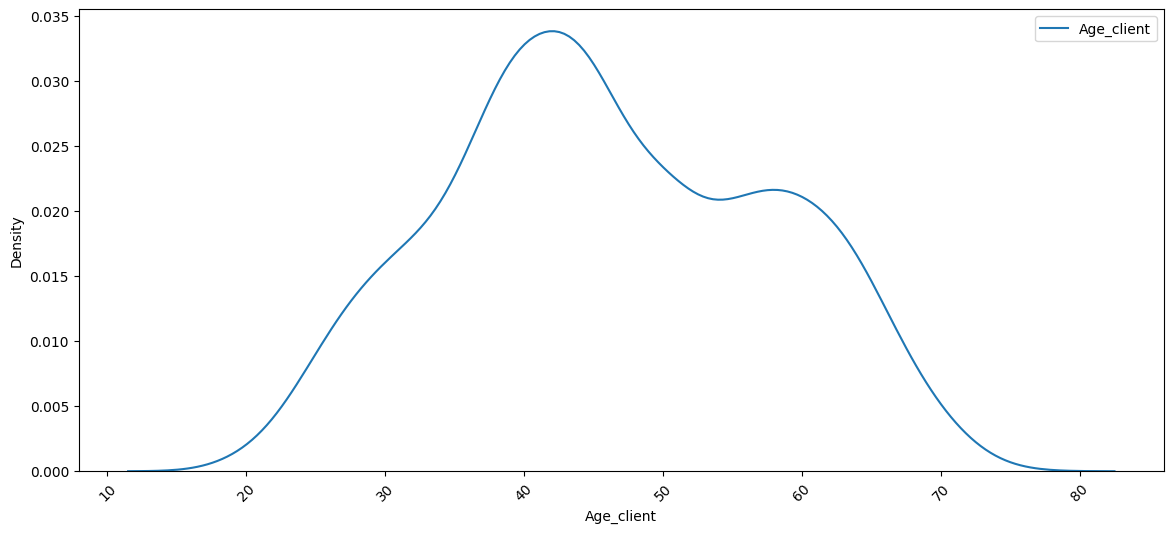

In [ ]:
kde(df, 'Age_client')

У нас близький до нормального розподіл клієнтів за віком і переважають клієнти 40-60 років.

Розподіл кількості витрат за сумами витрат на клієнта

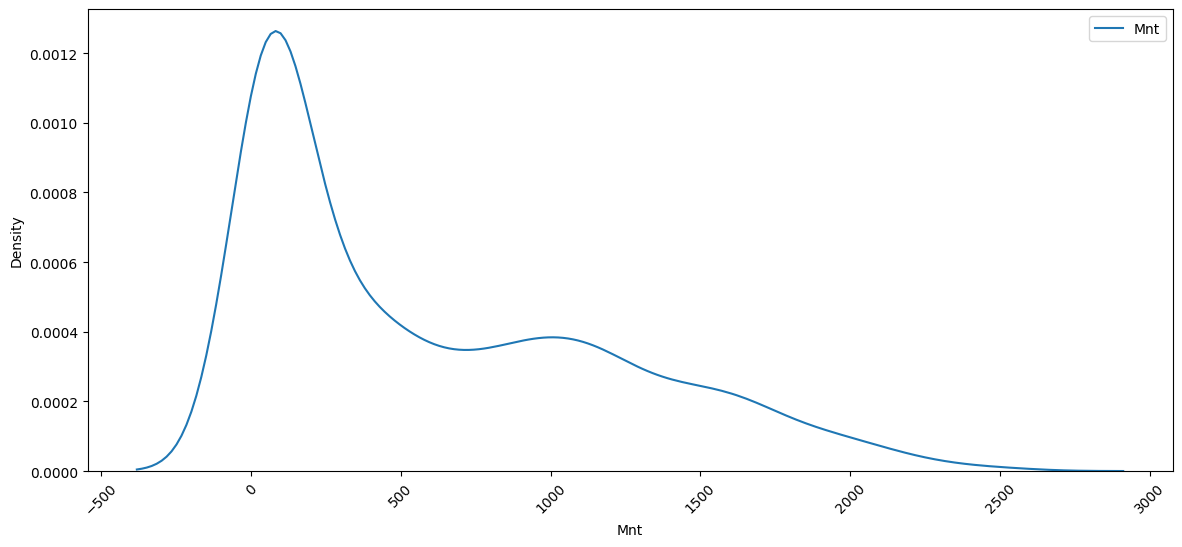

In [ ]:
kde(df, 'Mnt')

Більшість клієнтів витрачають до 500 у.0. Але кореляції між віком клієнтів та витратами немає.

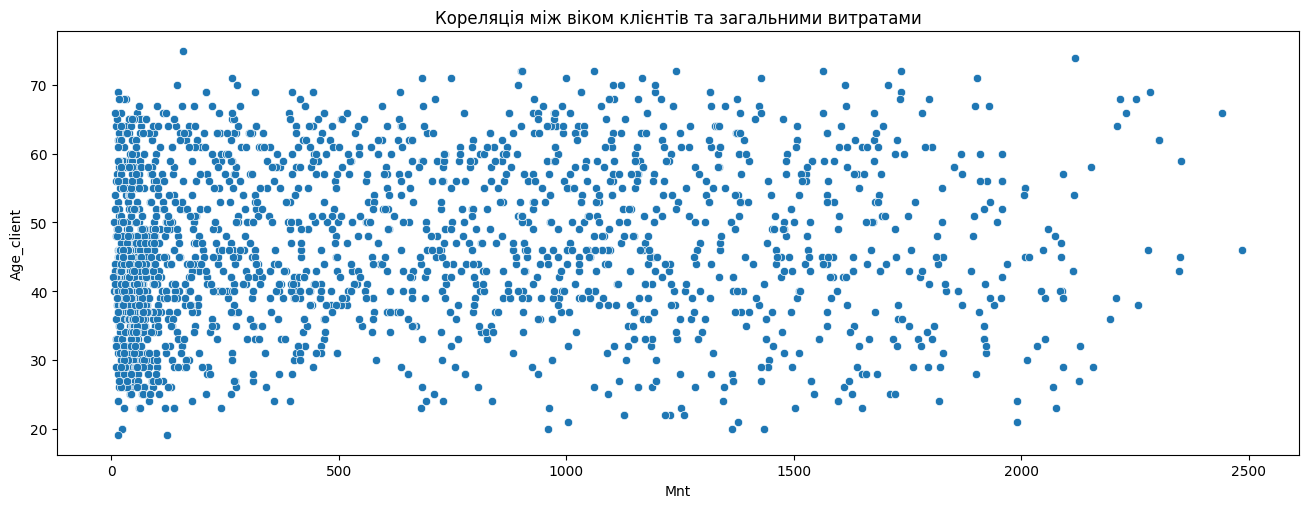

In [ ]:
plt.figure(figsize = (14, 6))

plt.title('Кореляція між віком клієнтів та загальними витратами')
sns.scatterplot(x = df[df['Mnt'] < 2500].Mnt, y = df.Age_client, data = df)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

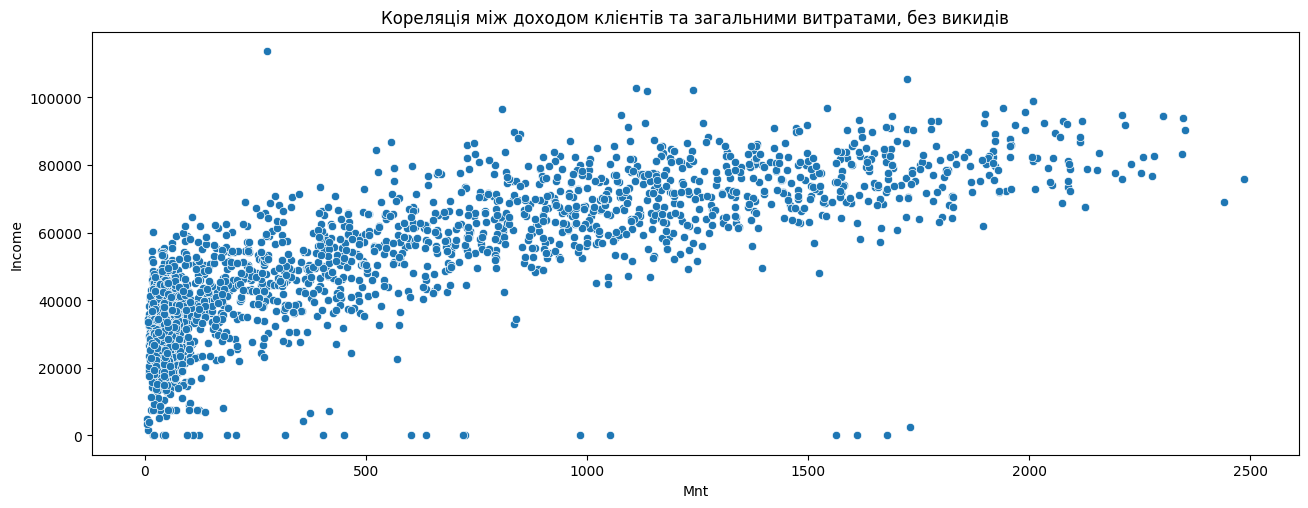

In [ ]:
plt.figure(figsize = (14, 6))

plt.title('Кореляція між доходом клієнтів та загальними витратами, без викидів')
sns.scatterplot(x = df[df['Mnt'] < 2500].Mnt, y = df[df['Income']<118350.5].Income, data = df)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

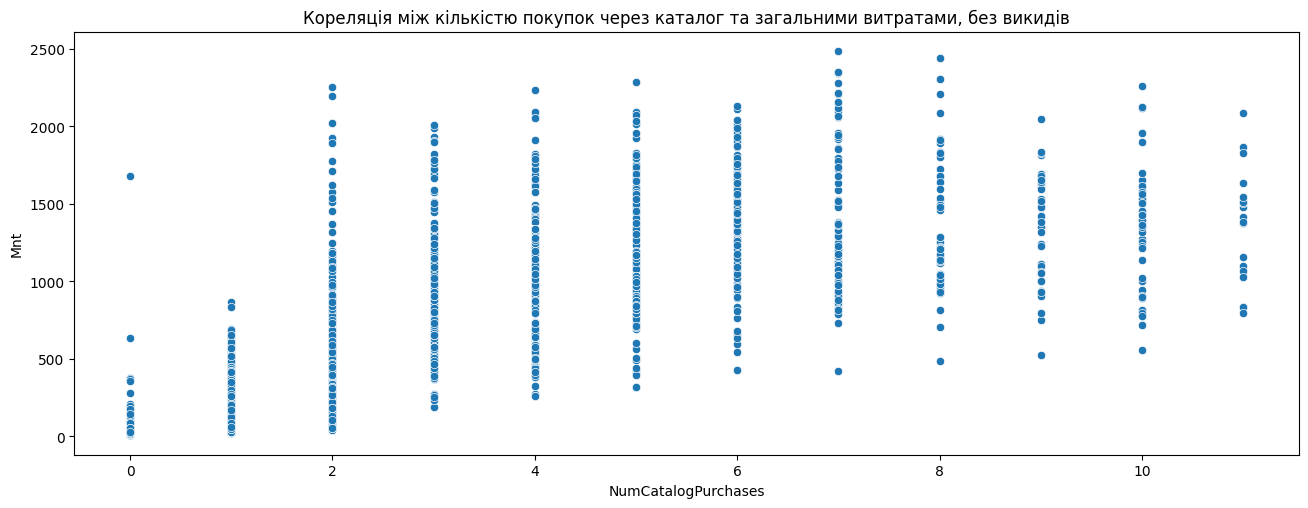

In [ ]:
plt.figure(figsize = (14, 6))

plt.title('Кореляція між кількістю покупок через каталог та загальними витратами, без викидів')
sns.scatterplot(y = df[df['Mnt'] < 2500].Mnt, x = df[df['NumCatalogPurchases']<12].NumCatalogPurchases, data = df)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

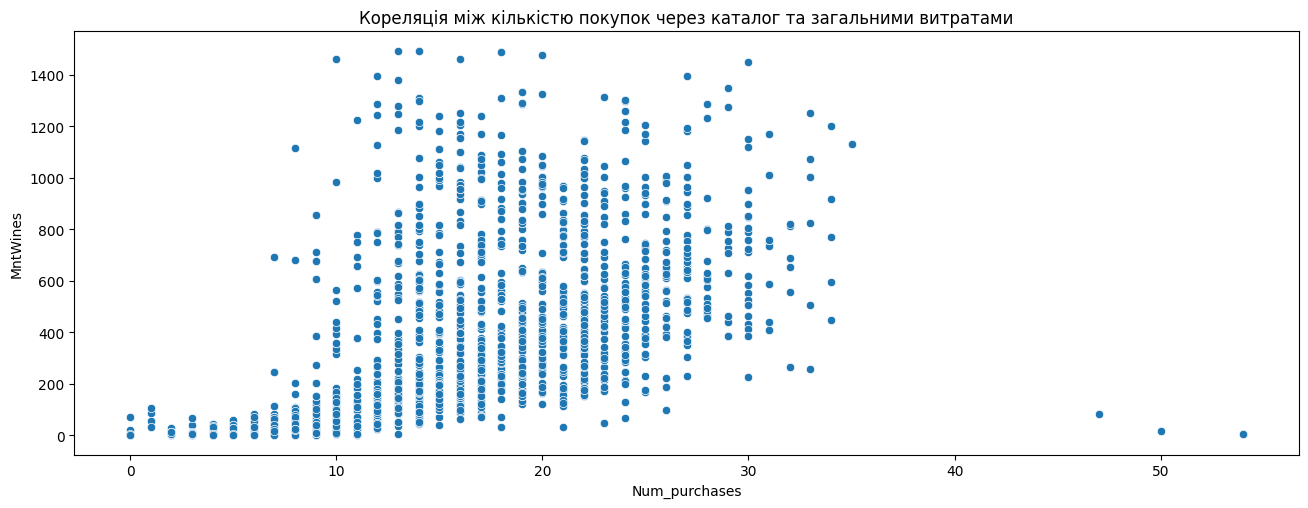

In [ ]:
plt.figure(figsize = (14, 6))

plt.title('Кореляція між кількістю покупок через каталог та загальними витратами')
sns.scatterplot(y = df.MntWines, x = df.Num_purchases, data = df)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

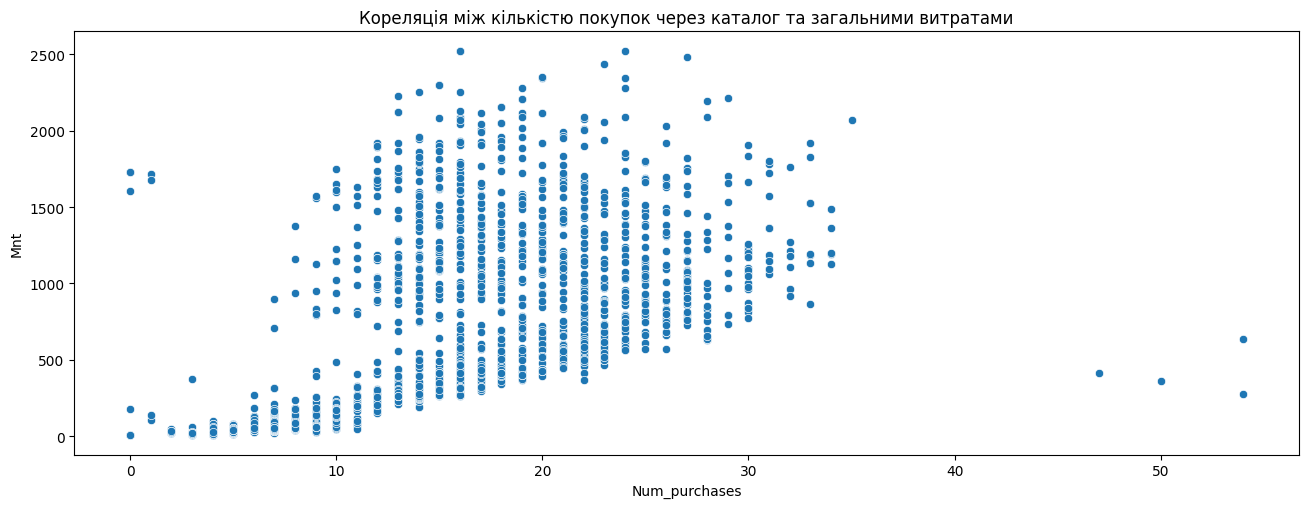

In [ ]:
plt.figure(figsize = (14, 6))

plt.title('Кореляція між кількістю покупок та загальними витратами')
sns.scatterplot(y = df.Mnt, x = df.Num_purchases, data = df)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

In [ ]:
zvit_columns = creat_zvit_num(df)
zvit_columns

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


,Назва колонки,Викиди,Розподіл_даних,План_дій,Висновки
0,Year_Birth,Немає викидів,"Ненормальний (Лівостороння, Слабка асиметрія)",Розглянути трансформацію (Квадрат або інверсія...,NaN
1,Income,Викиди від 118646.5 до 666666.0,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
2,Kidhome,Немає викидів,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути трансформацію (Логарифмічне або ква...,NaN
3,Teenhome,Немає викидів,"Ненормальний (Правостороння, Середня асиметрія)",Розглянути трансформацію (Логарифмічне або ква...,NaN
4,Recency,Немає викидів,"Ненормальний (Лівостороння, Слабка асиметрія)",Розглянути трансформацію (Квадрат або інверсія...,NaN
5,MntWines,Викиди від 1224.0 до 1493,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
6,MntFruits,Викиди від 81.0 до 199,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
7,MntMeatProducts,Викиди від 556.0 до 1725,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
8,MntFishProducts,Викиди від 120.5 до 259,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN
9,MntSweetProducts,Викиди від 81.0 до 263,"Ненормальний (Правостороння, Сильна асиметрія)",Розглянути видалення або заміну викидів,NaN


Датасет з усімв викидами, окрім нелогічних в колонках з небалансованими класами.

In [ ]:
df_vykyd_f = df[(df['Income'] > 118646.5) | (df['Mnt'] > 2509.0) |
                (df['Num_purchases']>40) | (df['ASP'] > 116.7)| (df['MntWines'] > 1224)|
                (df['MntFruits'] > 81.0)| (df['MntMeatProducts'] > 556.0)|
                (df['MntFishProducts'] > 120.5)| (df['MntSweetProducts'] > 81)|
                (df['MntGoldProds'] > 126)]
df_vykyd_f.shape

(643, 39)

Тоді нам потрібно видалити або внести зміни в 30% даних, що є сутттєвою зміною в даних. З огляду на це, викидами, які потрібно виокремити з датасету, який буде передаватися на кластеризацію, пропоную вважати викиди, які в узагальнюючих колонках.

Створюємо дані, де є викиди в узагальнюючих колонках.

In [ ]:
df_vykyd = df[(df['Income'] > 118646.5) | (df['Mnt'] > 2509.0) | (df['Num_purchases']>40) | (df['ASP'] > 116.7)]
df_vykyd.shape

(106, 39)

Створюємо дані, які не містять викиди

In [ ]:
df_clean = df[(df['Income'] < 118646.5) & (df['Mnt'] < 2509.0) & (df['Num_purchases']<40) & (df['ASP'] < 116.7)]
df_clean.shape

(2131, 39)

In [ ]:
df_vykyd.to_csv('/content/drive/MyDrive/Python/ML/DATA/df_vykyd.csv', index=False)

In [ ]:
df_clean.to_csv('/content/drive/MyDrive/Python/ML/DATA/df_clean.csv', index=False)

#Висновки

В даному ноутбуці було проведено ряд досліджень даних про клієнтів, що допомогло визначити:
1. У 70% клієнтів є неповнолітні в сім'ї.
2. Якщо в сімї більше одного неповнолітнього, то більше 86%, що клієнту можна пропонувати товари для обох вікових груп неповнолітніх.
3. 64% клієнтів купляють у нас товари у всіх категоріях, а також 21% клієнтів придбають товари у 5 категоріях з шести.
4. З аналізу даних з колонки 'Mnt_count_list' можемо побачити, що відсутні переважаючі набори категорій (окрім 6 категорій з шести).
6. Найбільші продажи у компанії в категорії 'Wines'.
7. Лише менше 1 відсотка клієнтів не скористалися знижками або пропозиціями компанії.
8. У нас близький до нормального розподіл клієнтів за віком і переважають клієнти 40-60 років.
9. Більшість клієнтів витрачають до 500 у.0. Але кореляції між віком клієнтів та витратами немає.

В наступному ноутбуці буде проведено кластеризацію даних клієнтів для виявлення груп і створення портретів клієнтів за такими групами.